In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.sankey import Sankey
import seaborn as sns
import statsmodels.api as sm
import calendar
import matplotlib as mpl

from scipy import optimize

C:\Users\mfink\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
COLD_BP = 60
HOT_BP = 75
FIRST_POWERWALL_DAY = 603
POWERWALL_DAYSINCEBEGINNING = [604, 605, 607, 608, 610, 638, 642, 643,
       664, 665, 670, 672, 706, 707, 721, 722, 726, 728, 742, 749, 751, 765, 770, 776, 785]

POWERWALL_COLD = [742, 749, 751, 765, 770, 776, 785]
POWERWALL_HOT = [604, 605, 607, 608, 610, 638, 642, 643,
       664, 665, 670, 672]
POWERWALL_SHOULDER = [706, 707, 721, 722, 726, 728]
POWERWALL_DISCHARGE_HOURS = [0,1,2,3,4,5,6,7,8,16,17,18,19,20,21,22,23]

LOADSHAPE_DAYS_TO_AVERAGE = 30

MONTH_ABB = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
FULL_MONTH_NAMES = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
                   'November', 'December']

mpl.rcParams['hatch.linewidth'] = 4

In [3]:
# import the important data data
# import data
raw_df = pd.read_csv('../produced_data_files/final_data_for_viz_thru_2018.csv')
raw_df['pandas_dt'] = raw_df['datetime'].apply(lambda x: pd.to_datetime(x))
raw_df['dayofweek'] = raw_df['pandas_dt'].apply(lambda x: x.dayofweek)
raw_df['weekdayQ'] = np.where(raw_df['dayofweek'] < 5, 1, 0)
raw_df['hdd'] = np.where(raw_df['Dry-bulb (F)'] < COLD_BP, (COLD_BP - raw_df['Dry-bulb (F)']) / 96.0, 0)
raw_df['cdd'] = np.where(raw_df['Dry-bulb (F)'] > HOT_BP, (raw_df['Dry-bulb (F)'] - HOT_BP) / 96.0, 0)
raw_df['total_dd'] = raw_df['hdd'] + raw_df['cdd']
raw_df['powerwall_discharge'] = np.where(np.all([raw_df['daysincebeginning'].isin(POWERWALL_DAYSINCEBEGINNING), raw_df['net_power_kW'] > 4, raw_df['hour'].isin(POWERWALL_DISCHARGE_HOURS)], axis=0),1,0)
raw_df['raw_consumption_estimation_kWh'] = np.where(raw_df['NGEN_kWh'] > 0, (raw_df['solaredge_kW']*.24 - raw_df['NGEN_kWh']) + raw_df['N01_kWh'], raw_df['N01_kWh'])
raw_df['final_consumption_estimation_kWh'] = np.where(raw_df['raw_consumption_estimation_kWh'] < 0, 0, raw_df['raw_consumption_estimation_kWh'])
raw_df[raw_df['powerwall_discharge']==1]

Unnamed: 0          IntervalEnd  Interconnect_kWh  N01_kWh  NGEN_kWh  \
52098       52098  2018-06-29-18:45:00               NaN     0.00      1.21   
52099       52099  2018-06-29-19:00:00               NaN     0.00      1.18   
52100       52100  2018-06-29-19:15:00               NaN     0.00      1.15   
52101       52101  2018-06-29-19:30:00               NaN     0.00      1.15   
52102       52102  2018-06-29-19:45:00               NaN     0.00      1.14   
52103       52103  2018-06-29-20:00:00               NaN     0.00      1.14   
52104       52104  2018-06-29-20:15:00               NaN     0.00      1.09   
52105       52105  2018-06-29-20:30:00               NaN     0.00      1.06   
52106       52106  2018-06-29-20:45:00               NaN     0.00      1.09   
52107       52107  2018-06-29-21:00:00               NaN     0.00      1.14   
52194       52194  2018-06-30-18:45:00               NaN     0.00      1.30   
52195       52195  2018-06-30-19:00:00               NaN     0.00      1.26   
52196       52196  2018-06-30-19:15:00               NaN     0.00      1.26   
52197       52197  2018-06-30-19:30:00               NaN     0.00      1.28   
52198       52198  2018-06-30-19:45:00               NaN     0.00      1.23   
52199       52199  2018-06-30-20:00:00               NaN     0.00      1.21   
52200       52200  2018-06-30-20:15:00               NaN     0.00      1.19   
52201       52201  2018-06-30-20:30:00               NaN     0.00      1.20   
52202       52202  2018-06-30-20:45:00               NaN     0.00      1.19   
52203       52203  2018-06-30-21:00:00               NaN     0.00      1.20   
52375       52375  2018-07-02-16:00:00               NaN     0.00      2.05   
52376       52376  2018-07-02-16:15:00               NaN     0.00      2.05   
52377       52377  2018-07-02-16:30:00               NaN     0.00      2.00   
52378       52378  2018-07-02-16:45:00               NaN     0.00      1.96   
52379       52379  2018-07-02-17:00:00               NaN     0.00      1.88   
52380       52380  2018-07-02-17:15:00               NaN     0.00      1.79   
52381       52381  2018-07-02-17:30:00               NaN     0.00      1.78   
52382       52382  2018-07-02-17:45:00               NaN     0.00      1.62   
52383       52383  2018-07-02-18:00:00               NaN     0.00      1.53   
52404       52404  2018-07-02-23:15:00               NaN     0.00      1.03   
...           ...                  ...               ...      ...       ...   
66020       66020  2018-11-21-19:15:00               NaN     0.00      1.06   
66021       66021  2018-11-21-19:30:00               NaN     0.03      1.06   
66208       66208  2018-11-23-18:15:00               NaN     0.00      1.10   
66209       66209  2018-11-23-18:30:00               NaN     0.00      1.19   
66210       66210  2018-11-23-18:45:00               NaN     0.00      1.18   
66211       66211  2018-11-23-19:00:00               NaN     0.00      1.17   
66212       66212  2018-11-23-19:15:00               NaN     0.00      1.18   
67548       67548  2018-12-07-17:15:00               NaN     0.00      1.14   
67549       67549  2018-12-07-17:30:00               NaN     0.00      1.12   
67550       67550  2018-12-07-17:45:00               NaN     0.00      1.13   
67551       67551  2018-12-07-18:00:00               NaN     0.00      1.02   
67556       67556  2018-12-07-19:15:00               NaN     0.00      1.10   
68028       68028  2018-12-12-17:15:00               NaN     0.00      1.01   
68564       68564  2018-12-18-07:15:00               NaN     0.00      1.18   
68565       68565  2018-12-18-07:30:00               NaN     0.00      1.16   
68566       68566  2018-12-18-07:45:00               NaN     0.00      1.17   
68567       68567  2018-12-18-08:00:00               NaN     0.00      1.20   
68568       68568  2018-12-18-08:15:00               NaN     0.00      1.20   
68569       68569  2018-12-18-08:30:00               NaN 

In [4]:
insolation_df = pd.read_csv('../raw_data_files/insolation_data/insolation.csv')
insolation_df['pandas_dt'] = insolation_df['local_time'].apply(lambda x: pd.to_datetime(x))
master_df = raw_df.merge(insolation_df, on='pandas_dt')

In [6]:
list(master_df.columns)

['Unnamed: 0_x',
 'IntervalEnd',
 'Interconnect_kWh',
 'N01_kWh',
 'NGEN_kWh',
 'datetime',
 'hour',
 'minute',
 'hourofday',
 'dayofmonth',
 'month',
 'year',
 'dayofyear',
 'daysincebeginning',
 'Timestamp',
 'Dew point (C)',
 'Dew point (F)',
 'Dry-bulb (C)',
 'Dry-bulb (F)',
 'RHum (%)',
 'Sea level pressure (mbar)',
 'Station pressure (mbar)',
 'degree of saturation',
 'humidity ratio',
 'enthalpy (J/g ref 0C)',
 'enthalpy (Btu/lbm ref 0F)',
 'specific volume (m^3/kg)',
 'specific volume (ft^3/lbm)',
 'wet bulb temperature (C)',
 'wet bulb temperature (F)',
 'Hr_End',
 'DA_Demand',
 'RT_Demand',
 'DA_LMP',
 'DA_EC',
 'DA_CC',
 'DA_MLC',
 'RT_LMP',
 'RT_EC',
 'RT_CC',
 'RT_MLC',
 'Dry_Bulb',
 'Dew_Point',
 'produced_Wh',
 'solaredge_kW',
 'month_diff',
 'new_month',
 'net_energy_kWh',
 'net_power_kW',
 'rolling_sum',
 'credit',
 'plot_hour',
 'pd_date',
 'Begin Date',
 'Coal',
 'Natural Gas',
 'Nuclear',
 'Hydro',
 'Landfill Gas',
 'Refuse',
 'Solar',
 'Wind',
 'Wood',
 'Oil',
 'Ot

In [7]:
carbon_g_per_kWh_dict = {
    'Coal': 820,
    'Natural Gas': 490,
    'Nuclear': 12,
    'Hydro': 24,
    'Landfill Gas': 490,
    'Refuse': 600,
    'Solar': 48,
    'Wind': 11.5,
    'Wood': 230,
    'Oil':600
}


def calculate_carbon(x, per_kWh=True):
    mix_sum = x[['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Landfill Gas', 'Refuse', 'Solar', 'Wind', 'Wood', 'Oil']].sum()
    
    total_carbon = ((x['Coal'] * carbon_g_per_kWh_dict['Coal']) + 
                    (x['Natural Gas'] * carbon_g_per_kWh_dict['Natural Gas']) + 
                    (x['Nuclear'] * carbon_g_per_kWh_dict['Nuclear']) + 
                    (x['Hydro'] * carbon_g_per_kWh_dict['Hydro']) + 
                    (x['Landfill Gas'] * carbon_g_per_kWh_dict['Landfill Gas']) + 
                    (x['Refuse'] * carbon_g_per_kWh_dict['Refuse']) + 
                    (x['Solar'] * carbon_g_per_kWh_dict['Solar']) + 
                    (x['Wind'] * carbon_g_per_kWh_dict['Wind']) +
                    (x['Wood'] * carbon_g_per_kWh_dict['Wood']) + 
                    (x['Oil'] * carbon_g_per_kWh_dict['Oil']))
    
    if per_kWh:
        return total_carbon / mix_sum
    else:
        return total_carbon
    
def calculate_marginal_carbon_per_kWh(x):
    total_marginal_fuels = x[['Coal_m', 'Natural Gas_m', 'Nuclear_m',
       'Hydro_m', 'Landfill Gas_m', 'Refuse_m', 'Solar_m', 'Wind_m', 'Wood_m',
       'Oil_m']].sum()
    if total_marginal_fuels == 0:
        return 390
    marginal_carbon = ((x['Coal_m'] * carbon_g_per_kWh_dict['Coal']) +
                       (x['Natural Gas_m'] * carbon_g_per_kWh_dict['Natural Gas']) +
                       (x['Nuclear_m'] * carbon_g_per_kWh_dict['Nuclear']) +
                       (x['Hydro_m'] * carbon_g_per_kWh_dict['Hydro']) +
                       (x['Landfill Gas_m'] * carbon_g_per_kWh_dict['Landfill Gas']) +
                       (x['Refuse_m'] * carbon_g_per_kWh_dict['Refuse']) +
                       (x['Solar_m'] * carbon_g_per_kWh_dict['Solar']) +
                       (x['Wind_m'] * carbon_g_per_kWh_dict['Wind']) +
                       (x['Wood_m'] * carbon_g_per_kWh_dict['Wood']) +
                       (x['Oil_m'] * carbon_g_per_kWh_dict['Oil'])) 
    return marginal_carbon / total_marginal_fuels
                    


master_df['marginal_carbon_g_per_kWh'] = master_df.apply(lambda x: calculate_marginal_carbon_per_kWh(x), axis=1)
master_df['carbon_g_per_kWh'] = master_df.apply(lambda x: calculate_carbon(x, True), axis=1)



In [8]:
master_df['carbon_g_per_kWh'].describe(), master_df['marginal_carbon_g_per_kWh'].describe()

(count    69879.000000
 mean       285.897566
 std         46.546171
 min        125.071916
 25%        255.305566
 50%        287.754047
 75%        319.422242
 max        410.791144
 Name: carbon_g_per_kWh, dtype: float64, count    69879.000000
 mean       389.841727
 std        152.591294
 min         11.500000
 25%        250.750000
 50%        490.000000
 75%        490.000000
 max        820.000000
 Name: marginal_carbon_g_per_kWh, dtype: float64)

In [9]:
master_df.to_csv('the_master_df_used.csv')

In [10]:
powerwall_moments_df = master_df[master_df['powerwall_discharge']==1]

In [196]:
# plot #1 - loadshapes for hottest weekdays, coldest weekdays, most climate-neutral days, and biggest duck days

# part a: find the x coldest weekdays, x hottest weekdays, and x shoulderiest weekdays
before_powerwall_df = master_df[master_df['daysincebeginning']<FIRST_POWERWALL_DAY]
weekday_df = before_powerwall_df[before_powerwall_df['weekdayQ']==1]
daily_df = weekday_df[['daysincebeginning', 'Dry-bulb (F)', 'total_dd']].groupby('daysincebeginning').mean().reset_index()
cold_days = list(daily_df.sort_values('Dry-bulb (F)')['daysincebeginning'].iloc[:LOADSHAPE_DAYS_TO_AVERAGE])
hot_days = list(daily_df.sort_values('Dry-bulb (F)', ascending=False)['daysincebeginning'].iloc[:LOADSHAPE_DAYS_TO_AVERAGE])
shoulder_days = list(daily_df.sort_values('total_dd')['daysincebeginning'].iloc[:LOADSHAPE_DAYS_TO_AVERAGE])

# finding the duck days
# get a list of daily stats by daysincebeginning
DUCK_MORNING = [4,5,6,7,8,9]
DUCK_MIDDAY = [11,12,13,14,15]
DUCK_EVENING = [17,18,19,20,21]

def find_duck_midday_valley(x):
    return x[x['hour'].isin(DUCK_MIDDAY)]['net_power_kW'].sum() / 4.0

def find_duck_sunset_peak(x):
    return x[x['hour'].isin(DUCK_EVENING)]['net_power_kW'].sum() / 4.0

def find_daily_duck_stat(x):
    return find_duck_midday_valley(x) - find_duck_sunset_peak(x)

def remove_frame(axis):
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.spines["left"].set_visible(False)
    axis.spines["bottom"].set_visible(False)
    return 0

duck_df = before_powerwall_df[['daysincebeginning', 'hour', 'net_power_kW']].groupby('daysincebeginning').agg(find_daily_duck_stat).reset_index()
duck_df.columns = ['daysincebeginning', 'duck_statistic', 'duck_statistic_duplicate']
duck_days = list(duck_df.sort_values('duck_statistic', ascending=False)['daysincebeginning'].iloc[:LOADSHAPE_DAYS_TO_AVERAGE])

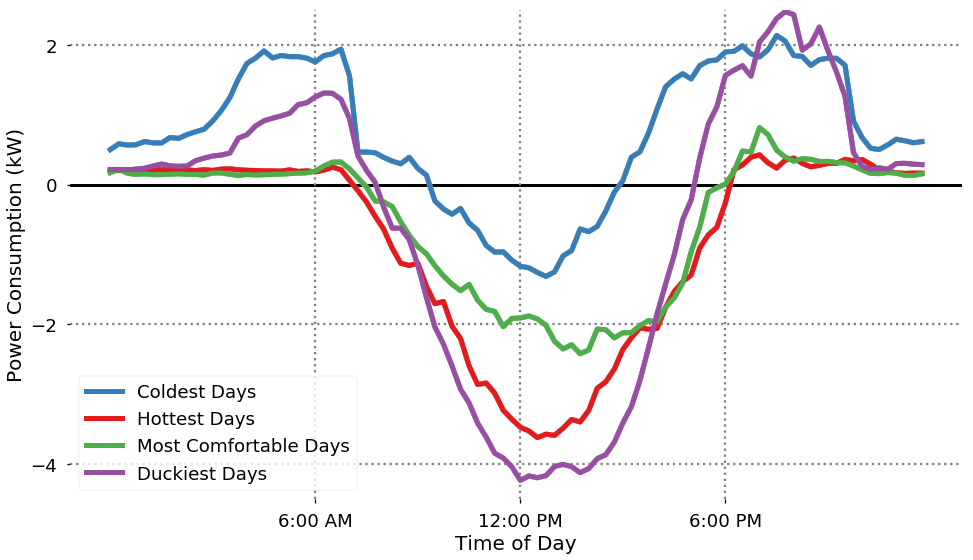

In [240]:
# make avg loadshapes and plot them
sns.set_context(context='talk', font_scale=1.4)
colors = ['#377eb8', '#e41a1c','#4daf4a','#984ea3']
labels = ['Coldest Days', 'Hottest Days', 'Most Comfortable Days', 'Duckiest Days']
handles = []

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(0, color='black', linewidth=3)



# plot 0,0 aesthetics

for vert in [6, 12, 18]:
    ax.axvline(x=vert, color='gray', linestyle=':')
for hori in [2, -2, -4]:
    ax.axhline(y=hori, color='gray', linestyle=':')

yticks = [-4, -2, 0, 2]
ax.set_yticks(yticks)
xticklabels = ['6:00 AM', '12:00 PM', '6:00 PM']
xticks = [6, 12, 18]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
remove_frame(ax)
ax.set_ylim(-4.5, 2.5)
ax.set_ylabel('Power Consumption (kW)')
ax.set_xlabel('Time of Day')

# making partial plots
for n, day_group in enumerate([cold_days, hot_days, shoulder_days, duck_days]):
    dates_df = weekday_df[weekday_df['daysincebeginning'].isin(day_group)]
    new_df = dates_df[['hourofday', 'net_power_kW']].groupby('hourofday').agg('mean').reset_index()
    ax.plot(new_df['hourofday'], -new_df['net_power_kW'], color=colors[n], linewidth=5)
    handles.append(mlines.Line2D([],[], color=colors[n], label=labels[n], linewidth=5))
    ax.legend(handles=handles, loc='lower left')
    fig.savefig(f'slides/slide_01_{labels[n]}.png', dpi=300)
    handles.pop()
    handles.append(mlines.Line2D([],[], color='silver', label=labels[n], linewidth=5))
    ax.plot(new_df['hourofday'], -new_df['net_power_kW'], color='silver', linewidth=5)
    
handles = []
# making final colored plot
for n, day_group in enumerate([cold_days, hot_days, shoulder_days, duck_days]):
    dates_df = weekday_df[weekday_df['daysincebeginning'].isin(day_group)]
    new_df = dates_df[['hourofday', 'net_power_kW']].groupby('hourofday').agg('mean').reset_index()
    ax.plot(new_df['hourofday'], -new_df['net_power_kW'], color=colors[n], linewidth=5)
    handles.append(mlines.Line2D([],[], color=colors[n], label=labels[n], linewidth=5))
    ax.legend(handles=handles, loc='lower left')


    fig.savefig('slides/slide01_seasonal_loadshapes.png', dpi=300)

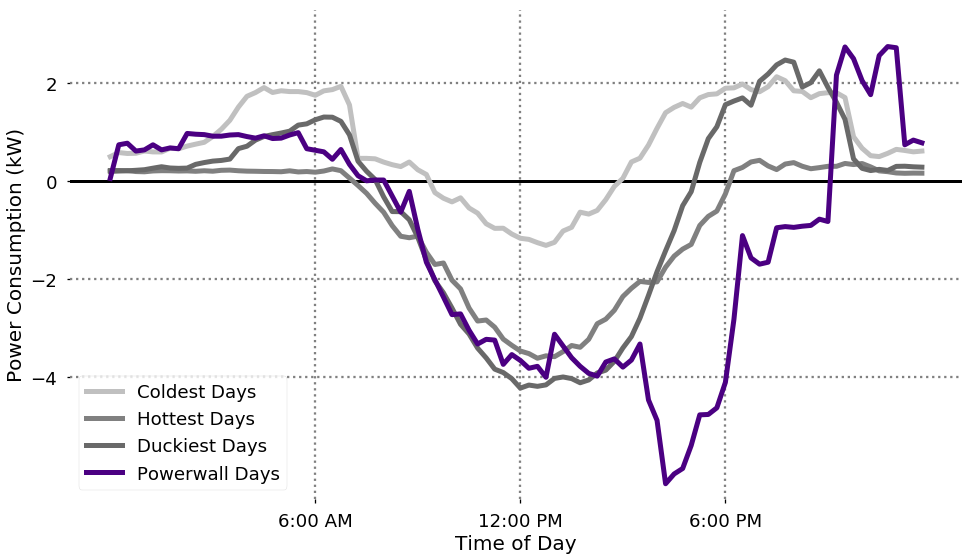

In [247]:
# make avg loadshapes and plot them
sns.set_context(context='talk', font_scale=1.4)
colors = ['silver', 'gray', 'dimgray']
labels = ['Coldest Days', 'Hottest Days', 'Duckiest Days']
handles = []

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(0, color='black', linewidth=3)

# plot 0,0 aesthetics

for vert in [6, 12, 18]:
    ax.axvline(x=vert, color='gray', linestyle=':')
for hori in [2, -2, -4]:
    ax.axhline(y=hori, color='gray', linestyle=':')

yticks = [-4, -2, 0, 2]
ax.set_yticks(yticks)
xticklabels = ['6:00 AM', '12:00 PM', '6:00 PM']
xticks = [6, 12, 18]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
remove_frame(ax)
ax.set_ylim(-6.5, 3.5)
ax.set_ylabel('Power Consumption (kW)')
ax.set_xlabel('Time of Day')

# making partial plots
for n, day_group in enumerate([cold_days, hot_days, duck_days]):
    dates_df = weekday_df[weekday_df['daysincebeginning'].isin(day_group)]
    new_df = dates_df[['hourofday', 'net_power_kW']].groupby('hourofday').agg('mean').reset_index()
    ax.plot(new_df['hourofday'], -new_df['net_power_kW'], color=colors[n], linewidth=5)
    handles.append(mlines.Line2D([],[], color=colors[n], label=labels[n], linewidth=5))

# making final colored plot
# for n, day_group in enumerate([cold_days, hot_days, shoulder_days, duck_days]):
#     dates_df = weekday_df[weekday_df['daysincebeginning'].isin(day_group)]
#     new_df = dates_df[['hourofday', 'net_power_kW']].groupby('hourofday').agg('mean').reset_index()
#     ax.plot(new_df['hourofday'], -new_df['net_power_kW'], color=colors[n], linewidth=5)
#     handles.append(mlines.Line2D([],[], color=colors[n], label=labels[n]))
#     ax.legend(handles=handles, loc='lower left')

hot_powerwall_days = [604, 605, 607, 608, 610]
pw_day_df = master_df[master_df['daysincebeginning'].isin(hot_powerwall_days)][['hourofday', 'net_power_kW']]
gpw_df = pw_day_df.groupby('hourofday').agg(np.mean).reset_index()

handles.append(mlines.Line2D([],[], color='indigo', label='Powerwall Days', linewidth=5))

ax.legend(handles=handles, loc='lower left')
ax.plot(gpw_df['hourofday'], -gpw_df['net_power_kW'], color='indigo', linewidth=5)
fig.savefig('slides/slide01_powerwall.png', dpi=300)

In [225]:
master_df.head()

Unnamed: 0_x          IntervalEnd  Interconnect_kWh  N01_kWh  NGEN_kWh  \
0             0  2017-01-01-00:15:00               0.0     0.02       0.0   
1             1  2017-01-01-00:30:00               0.0     0.03       0.0   
2             2  2017-01-01-00:45:00               0.0     0.04       0.0   
3             3  2017-01-01-01:00:00               0.0     0.02       0.0   
4             4  2017-01-01-01:15:00               0.0     0.02       0.0   

              datetime  hour  minute  hourofday  dayofmonth        ...         \
0  2017-01-01 00:15:00     0      15       0.25           1        ...          
1  2017-01-01 00:30:00     0      30       0.50           1        ...          
2  2017-01-01 00:45:00     0      45       0.75           1        ...          
3  2017-01-01 01:00:00     1       0       1.00           1        ...          
4  2017-01-01 01:15:00     1      15       1.25           1        ...          

   cdd  total_dd  powerwall_discharge  raw_consumption_estimation_kWh  \
0  0.0  0.267650                    0                            0.02   
1  0.0  0.264468                    0                            0.03   
2  0.0  0.261285                    0                            0.04   
3  0.0  0.260521                    0                            0.02   
4  0.0  0.263385                    0                            0.02   

  final_consumption_estimation_kWh  Unnamed: 0_y                 local_time  \
0                             0.02          5809  2016-12-31 19:15:00-05:00   
1                             0.03          5810  2016-12-31 19:30:00-05:00   
2                             0.04          5811  2016-12-31 19:45:00-05:00   
3                             0.02          5812  2016-12-31 20:00:00-05:00   
4                             0.02          5813  2016-12-31 20:15:00-05:00   

   solar_radiation_Wperm2  marginal_carbon_g_per_kWh  carbon_g_per_kWh  
0                0.445833                      490.0        237.176530  
1                0.383333                      490.0        237.176530  
2                0.320833                      490.0        232.710610  
3                0.258333                      490.0        232.539621  
4                0.195833                      490.0        233.873419  

[5 rows x 90 columns]

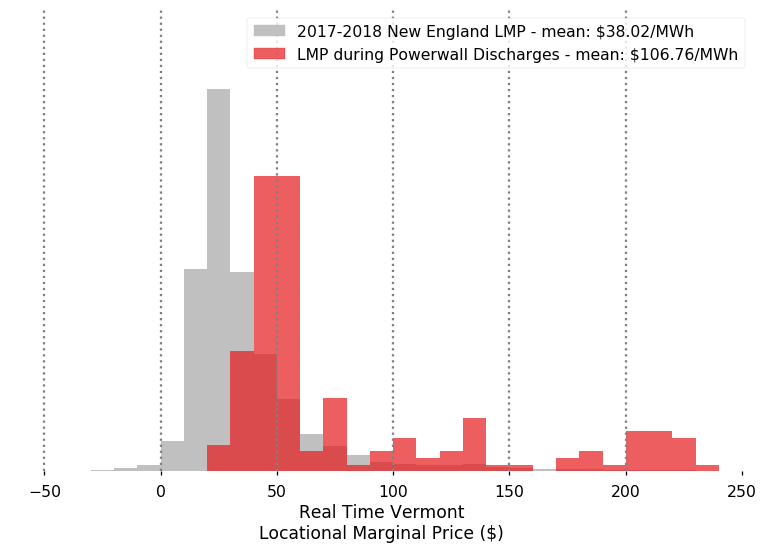

In [190]:
# slide 2a - histograms of energy 
sns.set_context(context='talk', font_scale=1.2)
fig, ax = plt.subplots(figsize=(11,8))


#ax.hist(powerwall_moments_df['RT_LMP'], bins=np.arange(-50,250,10), normed=1, color='firebrick')
remove_frame(ax)
frame1 = plt.gca()
frame1.axes.get_yaxis().set_ticks([])

vert_bars = [-50,0,50,100,150,200]
for vert in vert_bars:
    ax.axvline(x=vert, ymin=0, color='gray', linestyle=':')
    #ax.text(vert, -0.007, str(vert),horizontalalignment='center')


ax.set_xlabel('Real Time Vermont\nLocational Marginal Price ($)')
ax.set_ylim(0, .04)
ax.hist(master_df['RT_LMP'], bins=np.arange(-50,250,10), normed=1, color=colors[0])
plt.tight_layout()
fig.savefig('slides/slide_2a2_powerwall_lmp_v1.png', dpi=300)

ax.hist(master_df['RT_LMP'], bins=np.arange(-50,250,10), normed=1, color='silver', alpha=1)
overall_patch = mpatches.Patch(color='silver', label=f"2017-2018 New England LMP - mean: ${np.round(master_df['RT_LMP'].mean(), 2)}/MWh")
ax.hist(powerwall_moments_df['RT_LMP'], bins=np.arange(-50,250,10), normed=1, color=colors[1])
powerwall_patch = mpatches.Patch(color=colors[1], label=f"LMP during Powerwall Discharges - mean: ${np.round(powerwall_moments_df['RT_LMP'].mean(), 2)}/MWh")
ax.legend(handles=[overall_patch, powerwall_patch], loc='upper right')

fig.savefig('slides/slide_2a2_powerwall_lmp_v2.png', dpi=300)

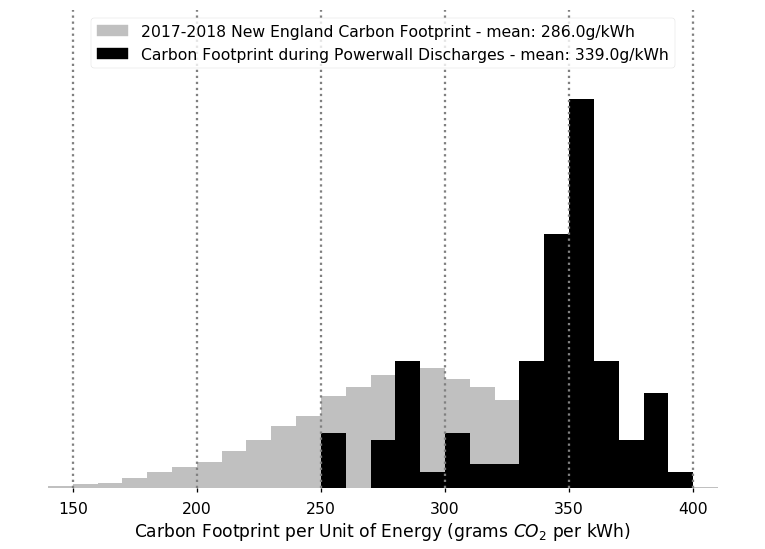

In [236]:
# slide 2b - histograms of carbon 
sns.set_context(context='talk', font_scale=1.2)
fig, ax = plt.subplots(figsize=(11,8))


#ax.hist(powerwall_moments_df['RT_LMP'], bins=np.arange(-50,250,10), normed=1, color='firebrick')
remove_frame(ax)
frame1 = plt.gca()
frame1.axes.get_yaxis().set_ticks([])

vert_bars = np.arange(100, 500, 50)
for vert in vert_bars:
    ax.axvline(x=vert, ymin=0, color='gray', linestyle=':')
    #ax.text(vert, -0.007, str(vert),horizontalalignment='center')

bins = np.arange(100,500,10)

ax.set_xlabel('Carbon Footprint per Unit of Energy (grams $CO_2$ per kWh)')
ax.set_xlim(125, 425)
ax.set_ylim(0, .034)
ax.hist(master_df['carbon_g_per_kWh'], bins=bins, normed=1, color=colors[0])
plt.tight_layout()
fig.savefig('slides/slide_2b2_carbon_powerwall_lmp_v1.png', dpi=300)

ax.hist(master_df['carbon_g_per_kWh'], bins=bins, normed=1, color='silver', alpha=1)
overall_patch = mpatches.Patch(color='silver', label=f"2017-2018 New England Carbon Footprint - mean: {np.round(master_df['carbon_g_per_kWh'].mean(), 0)}g/kWh")
ax.hist(powerwall_moments_df['carbon_g_per_kWh'], bins=bins, normed=1, color='black')
powerwall_patch = mpatches.Patch(color='black', label=f"Carbon Footprint during Powerwall Discharges - mean: {np.round(powerwall_moments_df['carbon_g_per_kWh'].mean(), 0)}g/kWh", alpha=1)
ax.legend(handles=[overall_patch, powerwall_patch], loc='upper center')

fig.savefig('slides/slide_2b2_carbon_powerwall_lmp_v2.png', dpi=300)

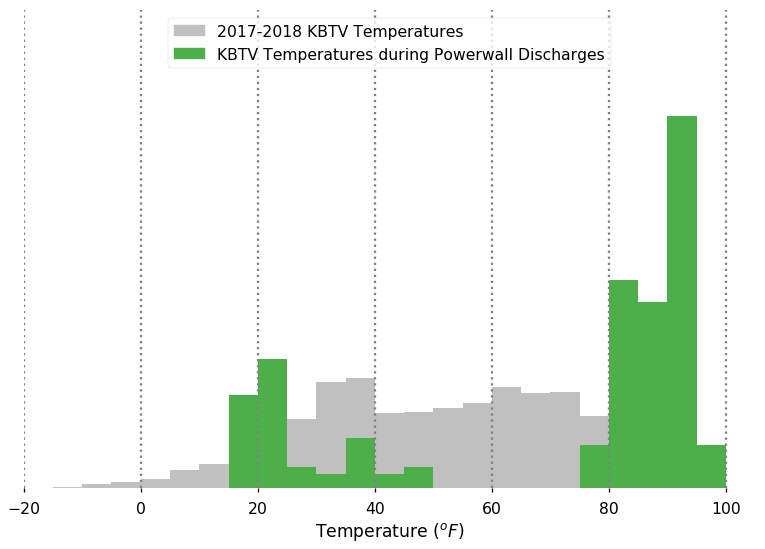

In [206]:
# slide 2c - histograms of powerwall temperature 
sns.set_context(context='talk', font_scale=1.2)
fig, ax = plt.subplots(figsize=(11,8))

temperature_df = master_df[master_df['Dry-bulb (F)']>-100]
pw_temp_df = powerwall_moments_df[powerwall_moments_df['Dry-bulb (F)']>-100]

#ax.hist(powerwall_moments_df['RT_LMP'], bins=np.arange(-50,250,10), normed=1, color='firebrick')
remove_frame(ax)
frame1 = plt.gca()
frame1.axes.get_yaxis().set_ticks([])

vert_bars = np.arange(-20, 101, 20)
for vert in vert_bars:
    ax.axvline(x=vert, ymin=0, color='gray', linestyle=':')
    #ax.text(vert, -0.007, str(vert),horizontalalignment='center')

bins = np.arange(-25,105,5)

ax.set_xlabel('Temperature ($^oF$)')
ax.set_xlim(-20, 105)
ax.set_ylim(0, .08)
ax.hist(temperature_df['Dry-bulb (F)'], bins=bins, normed=1, color=colors[0])
plt.tight_layout()
fig.savefig('slides/slide_2c2_temperature_powerwall_lmp_v1.png', dpi=300)

ax.hist(temperature_df['Dry-bulb (F)'], bins=bins, normed=1, color='silver', alpha=1)
overall_patch = mpatches.Patch(color='silver', label=f"2017-2018 KBTV Temperatures")
ax.hist(pw_temp_df['Dry-bulb (F)'], bins=bins, normed=1, color=colors[2])
powerwall_patch = mpatches.Patch(color=colors[2], label=f"KBTV Temperatures during Powerwall Discharges")
ax.legend(handles=[overall_patch, powerwall_patch], loc='upper center')

fig.savefig('slides/slide_2c2_temperature_powerwall_lmp_v2.png', dpi=300)

In [108]:
raw_df[['IntervalEnd', 
       'datetime', 'hour', 'minute', 'hourofday', 'dayofmonth', 'month',
       'year', 'dayofyear', 'daysincebeginning', 'Timestamp', 'Dew point (C)',
       'Dew point (F)', 'Dry-bulb (C)', 'Dry-bulb (F)', 'RHum (%)',
       'Sea level pressure (mbar)', 'Station pressure (mbar)',
       'degree of saturation', 'humidity ratio', 'enthalpy (J/g ref 0C)',
       'enthalpy (Btu/lbm ref 0F)', 'specific volume (m^3/kg)',
       'specific volume (ft^3/lbm)', 'wet bulb temperature (C)',
       'wet bulb temperature (F)', 'Hr_End', 'DA_Demand', 'RT_Demand',
       'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC',
       'RT_MLC', 'Dry_Bulb', 'Dew_Point', 'plot_hour', 'pd_date', 'Begin Date', 'Coal',
       'Natural Gas', 'Nuclear', 'Hydro', 'Landfill Gas', 'Refuse', 'Solar',
       'Wind', 'Wood', 'Oil', 'Other', 'Coal_m', 'Natural Gas_m', 'Nuclear_m',
       'Hydro_m', 'Landfill Gas_m', 'Refuse_m', 'Solar_m', 'Wind_m', 'Wood_m',
       'Oil_m', 'Other_m', 'pandas_dt', 'dayofweek', 'weekdayQ', 'hdd', 'cdd',
       'total_dd', 'powerwall_discharge', 'carbon_g_per_kWh',
       'marginal_carbon_g_per_kWh']].to_csv('iso_new_england_everything_2017-2018.csv')

In [14]:
def three_parameter_heating_model(x, x0, y0, k1):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x: k1*x + y0-k1*x0, lambda x: y0])

def three_parameter_cooling_model(x, x0, y0, k1):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x: y0, lambda x: k1*x + y0-k1*x0])

def four_parameter_model(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x: k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

def five_parameter_model(x, x0, x1, y0, k1, k2):
    return np.piecewise(x, [x < x0, (x>=x0)&(x<x1), x >= x1], [lambda x: k1*x + y0,
                                                               lambda x: y0+k1*x0,
                                                               lambda x: k2*(x-x1)+k1*x0+y0])

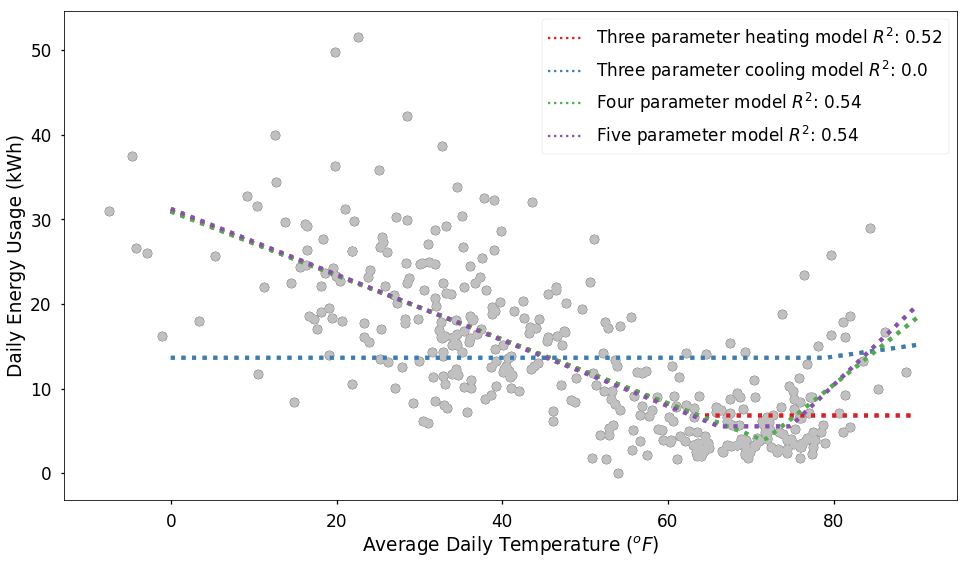

In [251]:
# slide 11 - mean, 3ph, 3pc, 4p and 5p models
sns.set_context('talk', font_scale=1.3)
cal_model_df = master_df[['year', 'month', 'dayofmonth', 'daysincebeginning', 'N01_kWh', 'Dry-bulb (F)']]

# caltrack models compare 2017 and 2018
cal_2017_df = cal_model_df[cal_model_df['year']==2017]
cal_2018_df = cal_model_df[cal_model_df['year']==2018]
sample_df = cal_2018_df[['daysincebeginning', 
                         'N01_kWh', 
                         'Dry-bulb (F)']].groupby('daysincebeginning').agg({'N01_kWh': np.sum, 'Dry-bulb (F)': np.mean}).reset_index()
sample_df.columns = ['daysincebeginning', 'energy_consumption_kWh', 'temp_F']
sample_df = sample_df[(np.isfinite(sample_df['energy_consumption_kWh']))&(np.isfinite(sample_df['temp_F']))]

# make 2018 all models
exes = np.array(sample_df['temp_F'])
wise = np.array(sample_df['energy_consumption_kWh'])

fig, ax = plt.subplots(figsize=(16, 9))
ax.set_xlabel('Average Daily Temperature ($^oF$)')
ax.set_ylabel('Daily Energy Usage (kWh)')
# save blank plot
fig.savefig('slide_11_blank model plot.png', dpi=300)

ax.scatter(exes, wise, color='black')
fig.savefig('slide_11_individual days.png', dpi=300)

ax.scatter(exes, wise, color='silver')

bp_search_range = 20,85
heating_sp_range = 20,70 # for 5p model only
cooling_sp_range = 72,100 # for 5p model only
model_temp_range = 0,90 # range that model will be shown on the plot
lt = 4 # line thickness

model_name = ['Three parameter heating model', 
              'Three parameter cooling model',
              'Four parameter model',
              'Five parameter model']
models = [three_parameter_heating_model, three_parameter_cooling_model, four_parameter_model, five_parameter_model]
colors = ["#e41a1c", "#377eb8", "#4daf4a", "#884eb3"]
legend_handles = []

# put all the models in silver on the plot

for n, model in enumerate(models):
    if model == three_parameter_heating_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([bp_search_range[0], -np.inf, -np.inf], [bp_search_range[1], np.inf, 0]))
    elif model == three_parameter_cooling_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([bp_search_range[0], -np.inf, 0], [bp_search_range[1], np.inf, np.inf]))
    elif model == four_parameter_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([bp_search_range[0], -np.inf, -np.inf, 0], [bp_search_range[1], np.inf, 0, np.inf]))
    elif model == five_parameter_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([heating_sp_range[0], cooling_sp_range[0], -np.inf, -np.inf, 0], [heating_sp_range[1], cooling_sp_range[1], np.inf, 0, np.inf]))


    # calculate model goodness of fit
    if (model == three_parameter_cooling_model)|(model == three_parameter_heating_model):
        model_y = np.array([model(exes, coeff[0], coeff[1], coeff[2]) for x in exes])[0]
    elif model == four_parameter_model:
        model_y = np.array([model(exes, coeff[0], coeff[1], coeff[2], coeff[3]) for x in exes])[0]
    elif model == five_parameter_model:
        model_y = np.array([model(exes, coeff[0], coeff[1], coeff[2], coeff[3], coeff[4]) for x in exes])[0]
    residuals = wise - model_y
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((wise - np.mean(wise))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # add models to the plot
    xd = np.linspace(model_temp_range[0], model_temp_range[1], 200)
    if (model == three_parameter_cooling_model)|(model == three_parameter_heating_model):
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2]), 
                      color='silver', 
                      linestyle=':',
                      linewidth=lt)
                
    elif model == four_parameter_model:
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2], coeff[3]), 
                      color='silver', 
                      linestyle=':',
                      linewidth=lt)
        
    elif model == five_parameter_model:
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2], coeff[3], coeff[4]), 
                      color='silver', 
                      linestyle=':',
                      linewidth=lt)

    fig.savefig('slide_11_all in silver.png', dpi=300)
    
# one at a time, highlight a model in its color, save the file, then cover it back up in silver.

for n, model in enumerate(models):
    if model == three_parameter_heating_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([bp_search_range[0], -np.inf, -np.inf], [bp_search_range[1], np.inf, 0]))
    elif model == three_parameter_cooling_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([bp_search_range[0], -np.inf, 0], [bp_search_range[1], np.inf, np.inf]))
    elif model == four_parameter_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([bp_search_range[0], -np.inf, -np.inf, 0], [bp_search_range[1], np.inf, 0, np.inf]))
    elif model == five_parameter_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([heating_sp_range[0], cooling_sp_range[0], -np.inf, -np.inf, 0], [heating_sp_range[1], cooling_sp_range[1], np.inf, 0, np.inf]))


    # calculate model goodness of fit
    if (model == three_parameter_cooling_model)|(model == three_parameter_heating_model):
        model_y = np.array([model(exes, coeff[0], coeff[1], coeff[2]) for x in exes])[0]
    elif model == four_parameter_model:
        model_y = np.array([model(exes, coeff[0], coeff[1], coeff[2], coeff[3]) for x in exes])[0]
    elif model == five_parameter_model:
        model_y = np.array([model(exes, coeff[0], coeff[1], coeff[2], coeff[3], coeff[4]) for x in exes])[0]
    residuals = wise - model_y
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((wise - np.mean(wise))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # add models to the plot
    xd = np.linspace(model_temp_range[0], model_temp_range[1], 200)
    if (model == three_parameter_cooling_model)|(model == three_parameter_heating_model):
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2]), 
                      color=colors[n], 
                      linestyle=':',
                      linewidth=lt)
                
    elif model == four_parameter_model:
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2], coeff[3]), 
                      color=colors[n], 
                      linestyle=':',
                      linewidth=lt)
        
    elif model == five_parameter_model:
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2], coeff[3], coeff[4]), 
                      color=colors[n], 
                      linestyle=':',
                      linewidth=lt)
    fig.savefig('slide_11 highlight color {}.png'.format(n), dpi=300)
    
    if (model == three_parameter_cooling_model)|(model == three_parameter_heating_model):
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2]), 
                      color='silver', 
                      linestyle=':',
                      linewidth=lt)
                
    elif model == four_parameter_model:
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2], coeff[3]), 
                      color='silver', 
                      linestyle=':',
                      linewidth=lt)
        
    elif model == five_parameter_model:
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2], coeff[3], coeff[4]), 
                      color='silver', 
                      linestyle=':',
                      linewidth=lt)

for n, model in enumerate(models):
    if model == three_parameter_heating_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([bp_search_range[0], -np.inf, -np.inf], [bp_search_range[1], np.inf, 0]))
    elif model == three_parameter_cooling_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([bp_search_range[0], -np.inf, 0], [bp_search_range[1], np.inf, np.inf]))
    elif model == four_parameter_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([bp_search_range[0], -np.inf, -np.inf, 0], [bp_search_range[1], np.inf, 0, np.inf]))
    elif model == five_parameter_model:
        coeff, covar_matrix = optimize.curve_fit(model, exes, wise, 
                                             bounds=([heating_sp_range[0], cooling_sp_range[0], -np.inf, -np.inf, 0], [heating_sp_range[1], cooling_sp_range[1], np.inf, 0, np.inf]))


    # calculate model goodness of fit
    if (model == three_parameter_cooling_model)|(model == three_parameter_heating_model):
        model_y = np.array([model(exes, coeff[0], coeff[1], coeff[2]) for x in exes])[0]
    elif model == four_parameter_model:
        model_y = np.array([model(exes, coeff[0], coeff[1], coeff[2], coeff[3]) for x in exes])[0]
    elif model == five_parameter_model:
        model_y = np.array([model(exes, coeff[0], coeff[1], coeff[2], coeff[3], coeff[4]) for x in exes])[0]
    residuals = wise - model_y
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((wise - np.mean(wise))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # add models to the plot
    xd = np.linspace(model_temp_range[0], model_temp_range[1], 200)
    if (model == three_parameter_cooling_model)|(model == three_parameter_heating_model):
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2]), 
                      color=colors[n], 
                      linestyle=':',
                      linewidth=lt)
                
    elif model == four_parameter_model:
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2], coeff[3]), 
                      color=colors[n], 
                      linestyle=':',
                      linewidth=lt)
        
    elif model == five_parameter_model:
        ax.plot(xd, model(xd, coeff[0], coeff[1], coeff[2], coeff[3], coeff[4]), 
                      color=colors[n], 
                      linestyle=':',
                      linewidth=lt)
            
    legend_handles.append(mlines.Line2D([],[],color=colors[n], linestyle=':', label=f'{model_name[n]} $R^2$: {np.around(r_squared, 2)}'))
ax.legend(handles=legend_handles)
fig.savefig('slide_11 all color.png', dpi=300)

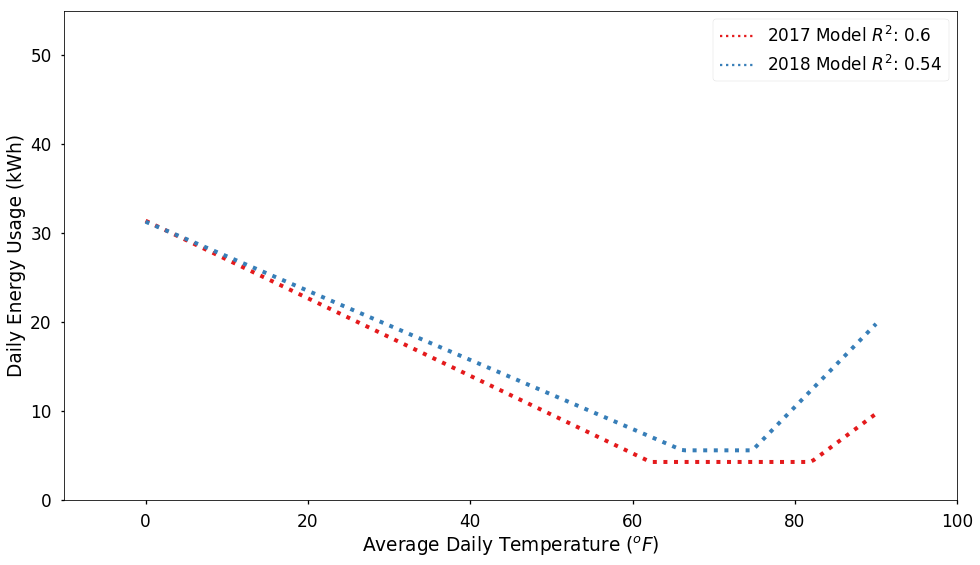

In [198]:
# slide 12 - find best 2017 and 2018 5p model paramters
sns.set_context('talk', font_scale=1.3)

bp_search_range = 20,85
heating_sp_range = 20,70 # for 5p model only
cooling_sp_range = 72,100 # for 5p model only
model_temp_range = 0,90 # range that model will be shown on the plot
lt = 4 # line thickness
colors = ["#e41a1c", "#377eb8", "#4daf4a", "#884eb3"]
legend_handles = []

cal_model_df = master_df[['year', 'month', 'dayofmonth', 'daysincebeginning', 'N01_kWh', 'Dry-bulb (F)']]

# caltrack models compare 2017 and 2018
cal_2017_df = cal_model_df[cal_model_df['year']==2017]
cal_2018_df = cal_model_df[cal_model_df['year']==2018]

def set_default_axis_view():
    ax.set_xlim(-10, 100)
    ax.set_ylim(0, 55)
    ax.set_xlabel('Average Daily Temperature ($^oF$)')
    ax.set_ylabel('Daily Energy Usage (kWh)')

def daily_group_df(df):
    g_df = df[['daysincebeginning', 
                         'N01_kWh', 
                         'Dry-bulb (F)']].groupby('daysincebeginning').agg({'N01_kWh': np.sum, 'Dry-bulb (F)': np.mean}).reset_index()
    g_df.columns = ['daysincebeginning', 'energy_consumption_kWh', 'temp_F']
    g_df = g_df[(np.isfinite(g_df['energy_consumption_kWh']))&(np.isfinite(g_df['temp_F']))]
    return g_df

g_2017_df = daily_group_df(cal_2017_df)
g_2018_df = daily_group_df(cal_2018_df)

# x series for plotting
xd = np.linspace(model_temp_range[0], model_temp_range[1], 200)

# 2017 data
x_2017 = np.array(g_2017_df['temp_F'])
y_2017 = np.array(g_2017_df['energy_consumption_kWh'])

# 2018 data
x_2018 = np.array(g_2018_df['temp_F'])
y_2018 = np.array(g_2018_df['energy_consumption_kWh'])

fig, ax = plt.subplots(figsize=(16, 9))
set_default_axis_view()
fig.savefig('slide_12_blank.png', dpi=300)

ax.scatter(x_2017, y_2017, color='black')
fig.savefig('slide_12_just_2017.png', dpi=300)

ax.scatter(x_2017, y_2017, color='silver')

coeff_2017, covar_matrix_2017 = optimize.curve_fit(five_parameter_model, x_2017, y_2017, 
                                             bounds=([heating_sp_range[0], cooling_sp_range[0], -np.inf, -np.inf, 0], [heating_sp_range[1], cooling_sp_range[1], np.inf, 0, np.inf]))

model_y_2017 = np.array([five_parameter_model(x_2017, coeff_2017[0], coeff_2017[1], 
                                      coeff_2017[2], coeff_2017[3], coeff_2017[4]) for x in x_2017])[0]

ax.plot(xd, five_parameter_model(xd, coeff_2017[0], coeff_2017[1], coeff_2017[2], coeff_2017[3], coeff_2017[4]), 
                      color=colors[0], 
                      linestyle=':',
                      linewidth=lt)

residuals = y_2017 - model_y_2017
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_2017 - np.mean(y_2017))**2)
r_squared_2017 = 1 - (ss_res / ss_tot)

legend_handles.append(mlines.Line2D([],[],color=colors[0], linestyle=':', label=f'2017 Model $R^2$: {np.around(r_squared_2017, 2)}'))

ax.legend(handles=legend_handles)
fig.savefig('slide_12 2017_complete.png', dpi=300)

plt.cla()
set_default_axis_view()
ax.plot(xd, five_parameter_model(xd, coeff_2017[0], coeff_2017[1], coeff_2017[2], coeff_2017[3], coeff_2017[4]), 
                      color=colors[0],
                      alpha=0.3,
                      linestyle=':',
                      linewidth=lt)

# remove legend handle and add new legend handle
legend_handles.pop()
legend_handles.append(mlines.Line2D([],[],color=colors[0], alpha=0.3,
                                    linestyle=':', label=f'2017 Model $R^2$: {np.around(r_squared_2017, 2)}'))
ax.legend(handles=legend_handles)

fig.savefig('slide_12_faded_2017_model.png', dpi=300)

ax.scatter(x_2018, y_2018, color='silver')

coeff_2018, covar_matrix_2018 = optimize.curve_fit(five_parameter_model, x_2018, y_2018, 
                                             bounds=([heating_sp_range[0], cooling_sp_range[0], -np.inf, -np.inf, 0], [heating_sp_range[1], cooling_sp_range[1], np.inf, 0, np.inf]))

model_y_2018 = np.array([five_parameter_model(x_2018, coeff_2018[0], coeff_2018[1], 
                                      coeff_2018[2], coeff_2018[3], coeff_2018[4]) for x in x_2018])[0]

ax.plot(xd, five_parameter_model(xd, coeff_2018[0], coeff_2018[1], coeff_2018[2], coeff_2018[3], coeff_2018[4]), 
                      color=colors[1], 
                      linestyle=':',
                      linewidth=lt)

residuals = y_2018 - model_y_2018
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_2018 - np.mean(y_2018))**2)
r_squared_2018 = 1 - (ss_res / ss_tot)

legend_handles.append(mlines.Line2D([],[],color=colors[1], linestyle=':', label=f'2018 Model $R^2$: {np.around(r_squared_2018, 2)}'))

ax.legend(handles=legend_handles)
fig.savefig('slide_12_2018_overlay_on_2017_model.png', dpi=300)
plt.cla()

set_default_axis_view()
ax.plot(xd, five_parameter_model(xd, coeff_2017[0], coeff_2017[1], coeff_2017[2], coeff_2017[3], coeff_2017[4]), 
                      color=colors[0],
                      linestyle=':',
                      linewidth=lt)
legend_handles = []
legend_handles.append(mlines.Line2D([],[],color=colors[0],
                                    linestyle=':', label=f'2017 Model $R^2$: {np.around(r_squared_2017, 2)}'))

ax.plot(xd, five_parameter_model(xd, coeff_2018[0], coeff_2018[1], coeff_2018[2], coeff_2018[3], coeff_2018[4]), 
                      color=colors[1], 
                      linestyle=':',
                      linewidth=lt)
legend_handles.append(mlines.Line2D([],[],color=colors[1],
                                    linestyle=':', label=f'2018 Model $R^2$: {np.around(r_squared_2018, 2)}'))
ax.legend(handles=legend_handles)
fig.savefig('slide_12_model_overlays.png', dpi=300)

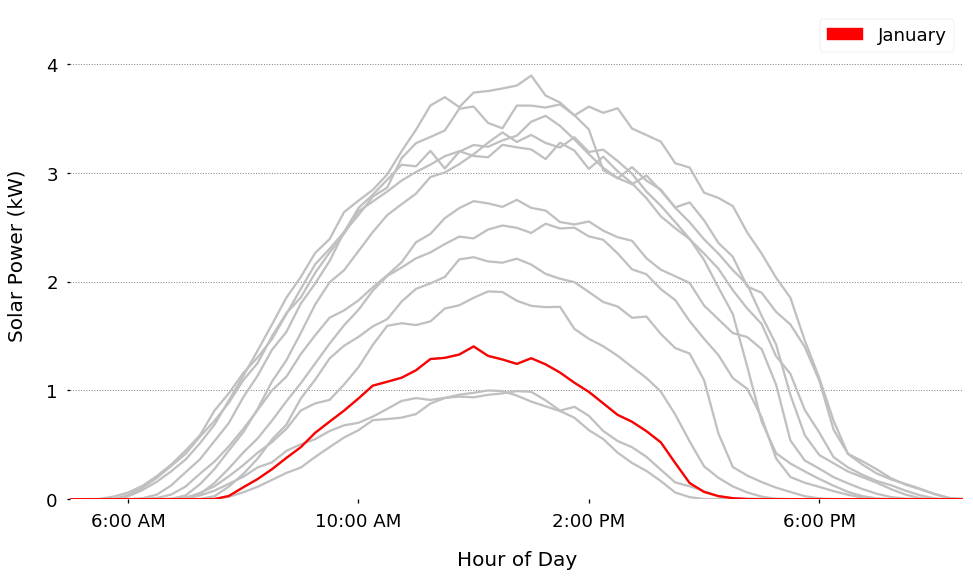

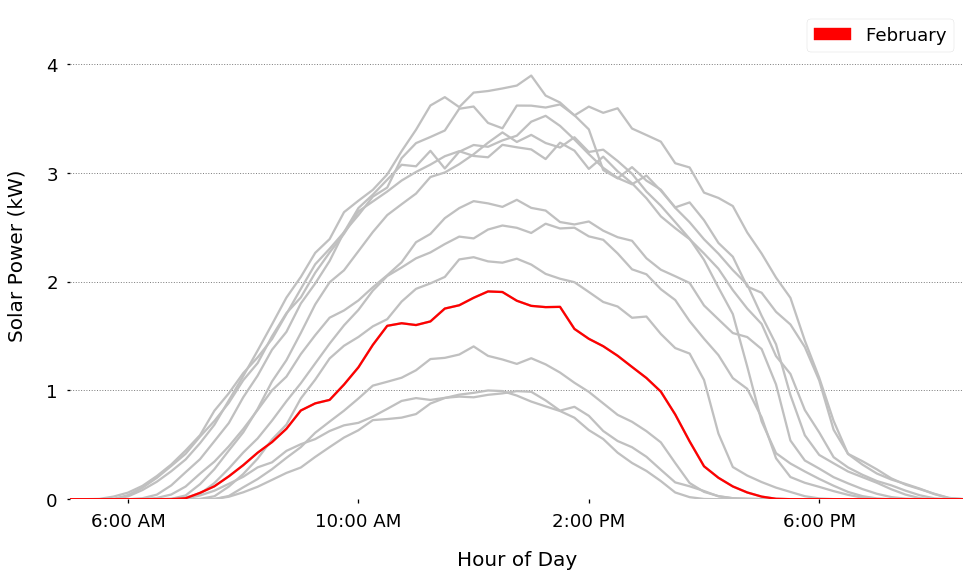

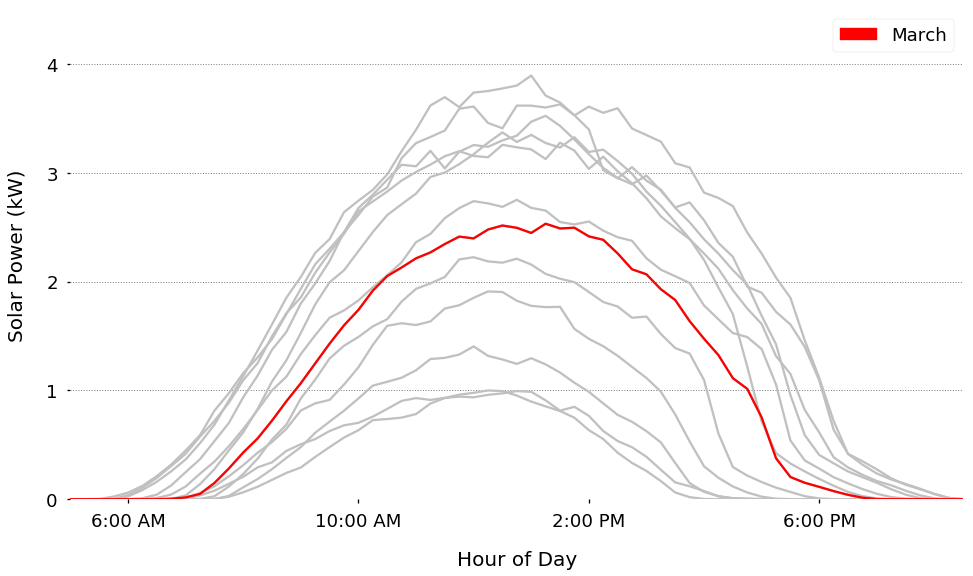

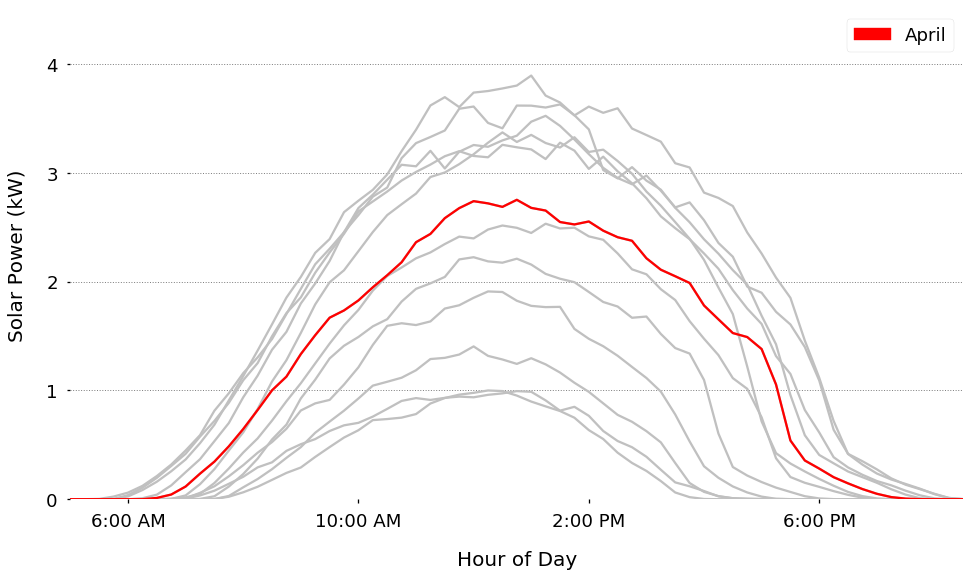

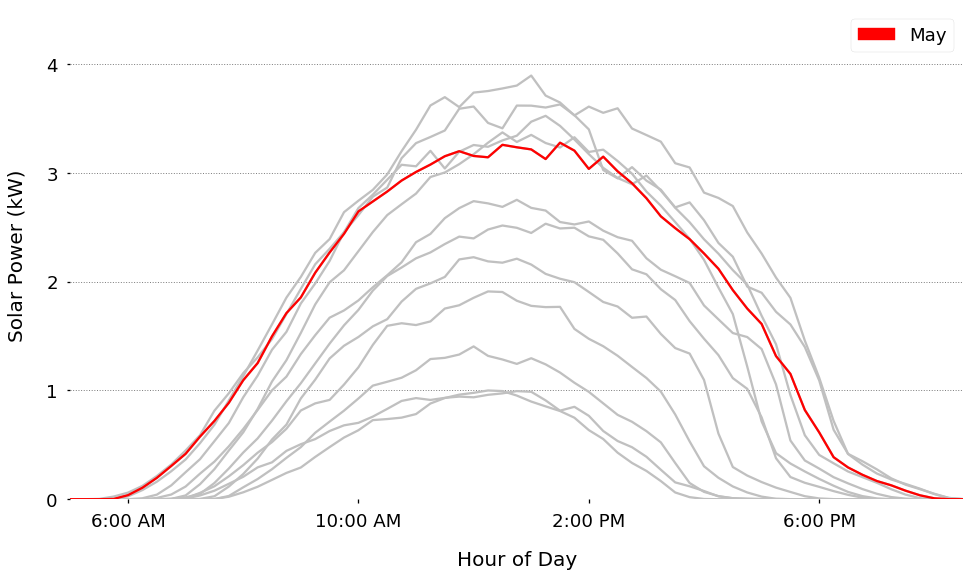

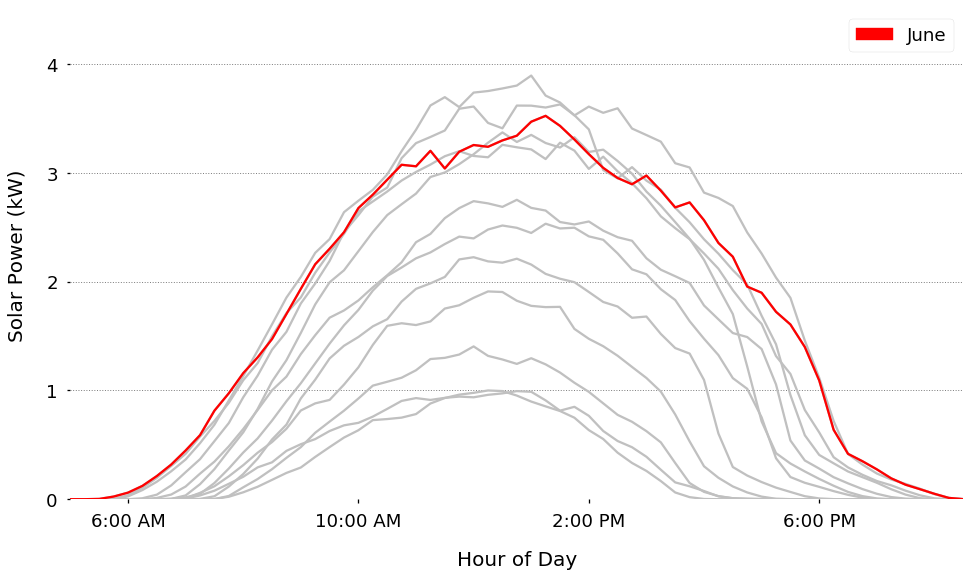

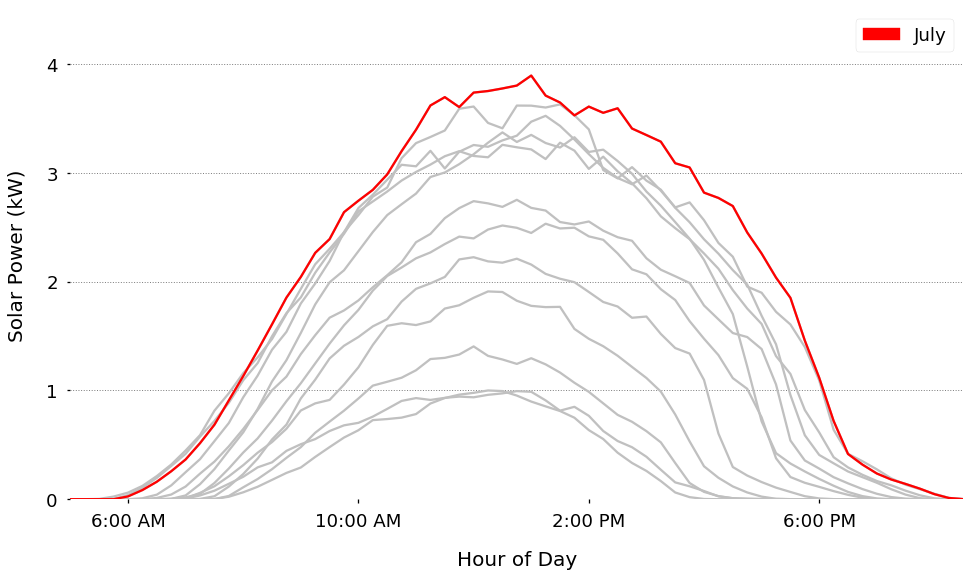

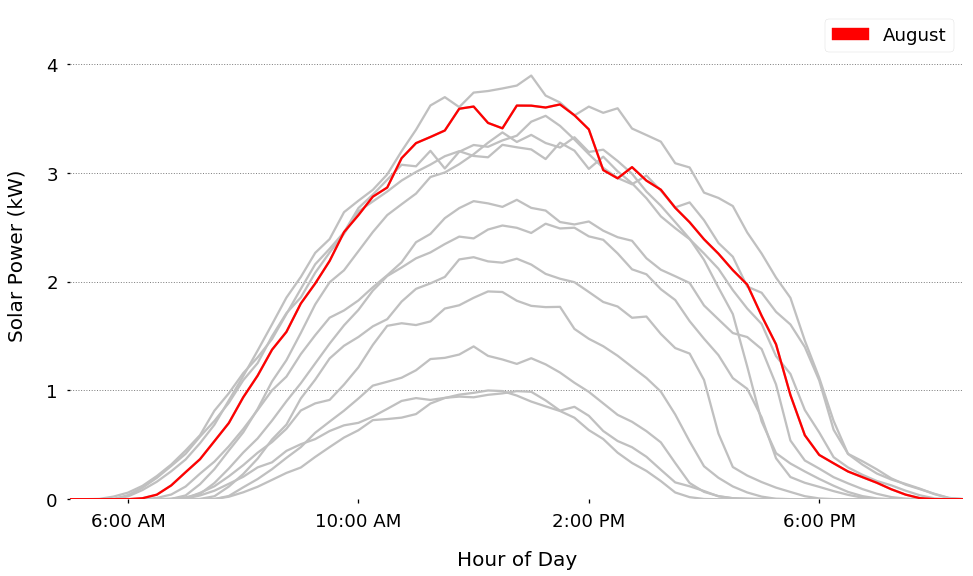

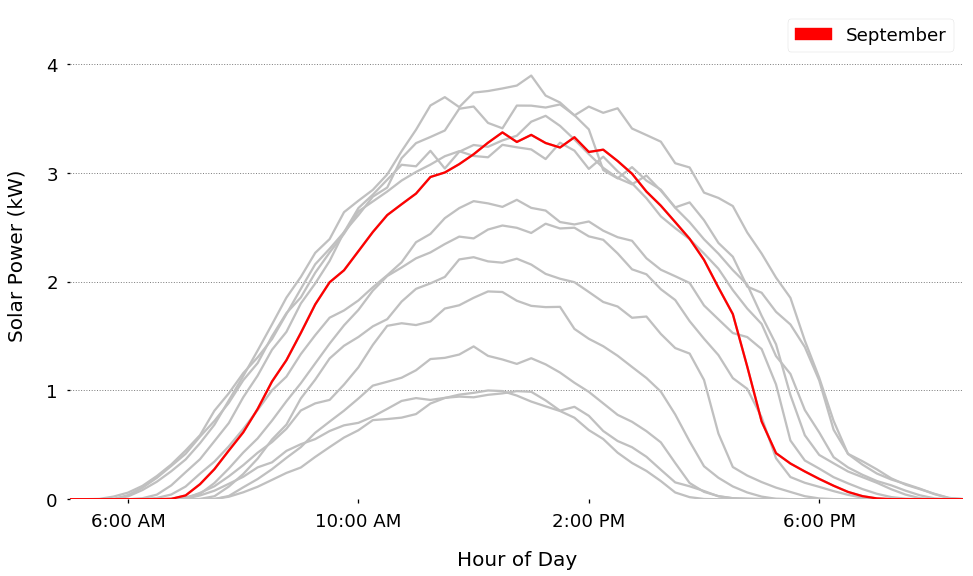

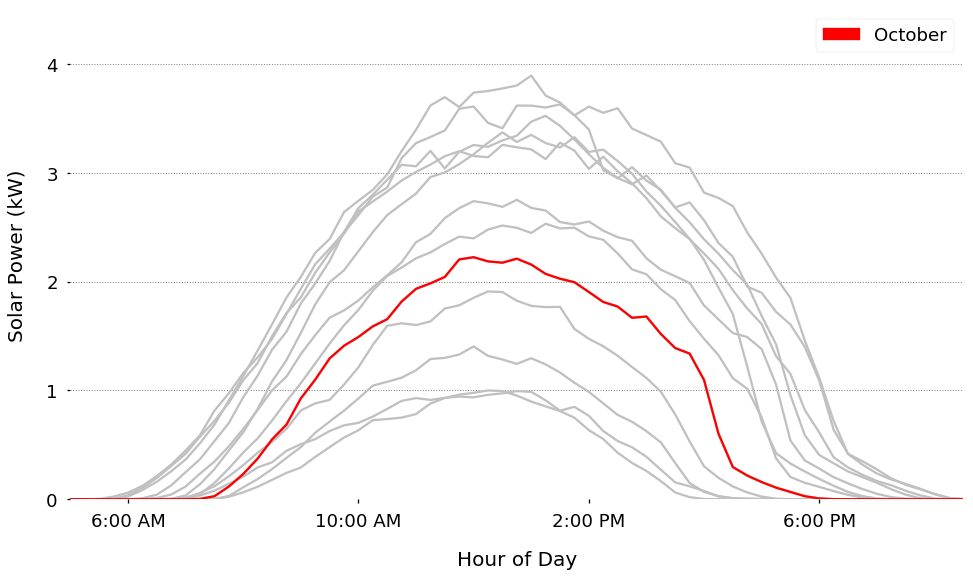

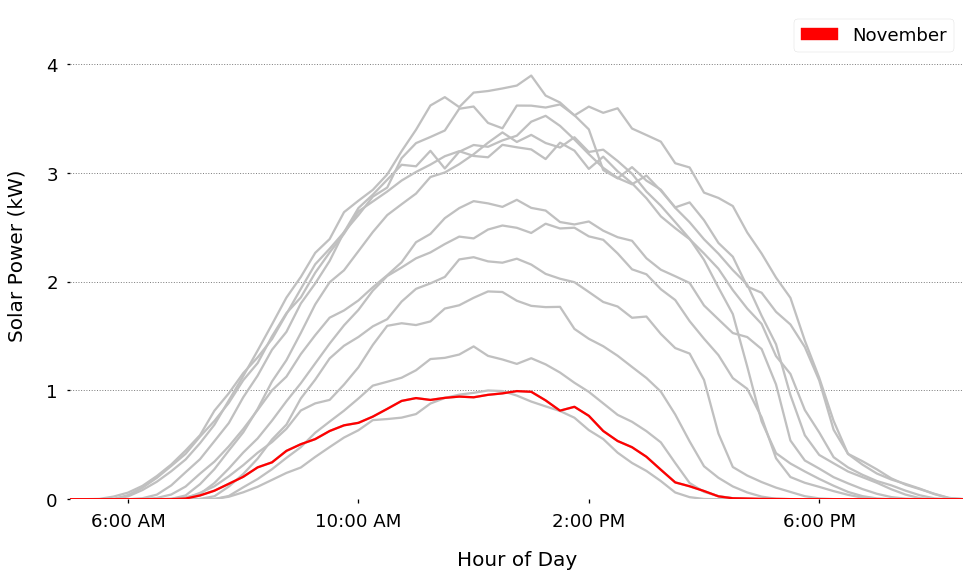

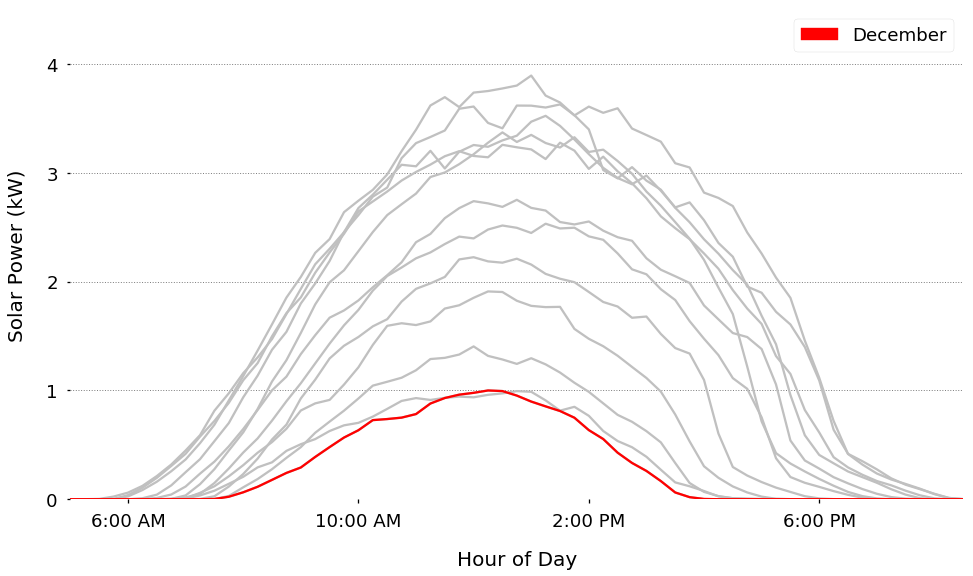

In [197]:
# slide 5 - solar production loadshapes - highlight july, december, april, and october
h_months = np.arange(1,13)
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']

for h_month in h_months:
    
    sns.set_context('talk', font_scale=1.4)
    slide5_df = raw_df[['solaredge_kW', 'hourofday', 'month']].groupby(['month', 'hourofday']).agg(np.mean).reset_index()

    fig, ax = plt.subplots(figsize=(16, 9))

    ax.set_xlim(5,20.5)
    ax.set_ylim(0, 4.5)
    remove_frame(ax)

    yticks = [0,1,2,3,4]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.set_ylabel('Solar Power (kW)')
    ax.yaxis.labelpad = 20

    for y in yticks:
        ax.axhline(y, color='gray', linewidth=1, linestyle=':')

    xticks = [6, 10, 14, 18]
    xticklabels = ['6:00 AM', '10:00 AM', '2:00 PM', '6:00 PM']
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Hour of Day')
    ax.xaxis.labelpad = 20

    for m in np.arange(1,13):
        highlight_df = slide5_df[slide5_df['month'] == m]
        exes = highlight_df['hourofday']
        whys = highlight_df['solaredge_kW']

        ax.plot(exes, whys, color='silver')

    special_df = slide5_df[slide5_df['month']==h_month]
    special_exes = special_df['hourofday']
    special_whys = special_df['solaredge_kW']
    ax.plot(special_exes, special_whys, color='red')
    #ax.plot(special_exes, special_whys, color=colors[(h_month-1)%6])
    
    special_patch = mpatches.Patch(color='red', label=f"{calendar.month_name[h_month]}")
    #special_patch = mpatches.Patch(color=colors[(h_month-1)%6], label=f"{calendar.month_name[h_month]}")
    ax.legend(handles=[special_patch], loc='upper right')
    fig.savefig('slide_05_production_redh_month_{}.png'.format(h_month), dpi=300)

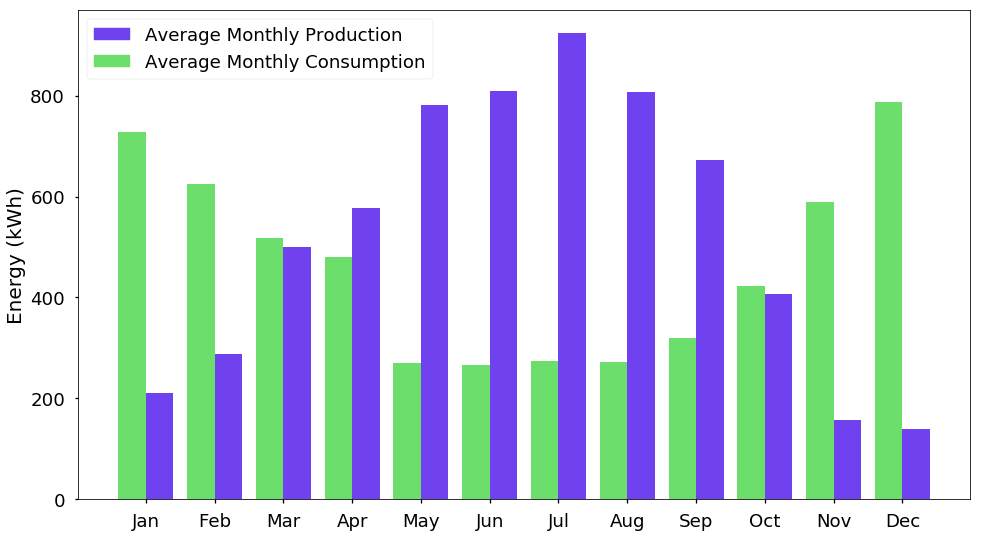

In [366]:
# slide 6 seasonal production problem
sns.set_context('talk', font_scale=1.4)
fig, ax = plt.subplots(figsize=(16, 9))

bar_width=0.4
mask_alpha = 0.85

exe_1 = np.arange(0.3, 12, 1)
exe_2 = np.arange(0.7, 12, 1)

monthly_df = master_df[['year', 'month', 'N01_kWh', 'NGEN_kWh', 'produced_Wh']].groupby(['year','month']).agg(np.sum).reset_index()



final_df = monthly_df[['month', 'N01_kWh', 'NGEN_kWh', 'produced_Wh']].groupby(['month']).agg(np.mean).reset_index()
final_df['produced_kWh'] = 0.97 * final_df['produced_Wh'] / 1000.0
final_df['consumed_kWh'] = (final_df['produced_kWh'] - final_df['NGEN_kWh']) + final_df['N01_kWh']

why_1 = list(final_df['consumed_kWh'])
why_2 = list(final_df['produced_kWh'])



ax.set_xticks(np.arange(0.5, 12, 1))
ax.set_xticklabels(MONTH_ABB)
ax.set_ylabel('Energy (kWh)')

production_patch = mpatches.Patch(color=colors[1], label='Average Monthly Production')
consumption_patch = mpatches.Patch(color=colors[0], label='Average Monthly Consumption')

def highlight_months(y_series, months_to_highlight):
    for index, item in enumerate(y_series):
        if index in months_to_highlight:
            y_series[index] = 0
    return y_series

summer_mask = [4, 5, 6, 7, 8]
shoulder_mask = [2,3,9]
winter_mask = [0, 1, 10, 11]
no_mask = np.arange(0,13)
ax.legend(handles=[production_patch, consumption_patch], loc='upper left')
mask = no_mask

ax.bar(exe_1, why_1, color=colors[0], width=bar_width)
ax.bar(exe_2, why_2, color=colors[1], width=bar_width)
con_y = highlight_months(why_1, mask)
pro_y = highlight_months(why_2, mask)
ax.bar(exe_1, con_y, color='white', width=bar_width, alpha=mask_alpha)
ax.bar(exe_2, pro_y, color='white', width=bar_width, alpha=mask_alpha)
fig.savefig('slide_solar_prod_monthly_no_mask.png', dpi=300)

# for n, mask in enumerate([winter_mask, summer_mask, no_mask], start=1):
#     con_y = highlight_months(why_1, mask)
#     pro_y = highlight_months(why_2, mask)
#     ax.bar(exe_1, why_1, color=colors[0], width=0.4)
#     ax.bar(exe_2, why_2, color=colors[1], width=0.4)
#     ax.bar(exe_1, con_y, color='silver', width=0.4, alpha=0.8)
#     ax.bar(exe_2, pro_y, color='silver', width=0.4, alpha=0.8)
   
#     fig.savefig('slide_solar_prod_monthly_{}.png'.format(n), dpi=300)

537.8380191300732 0.31017537104623927 166.8241071464448


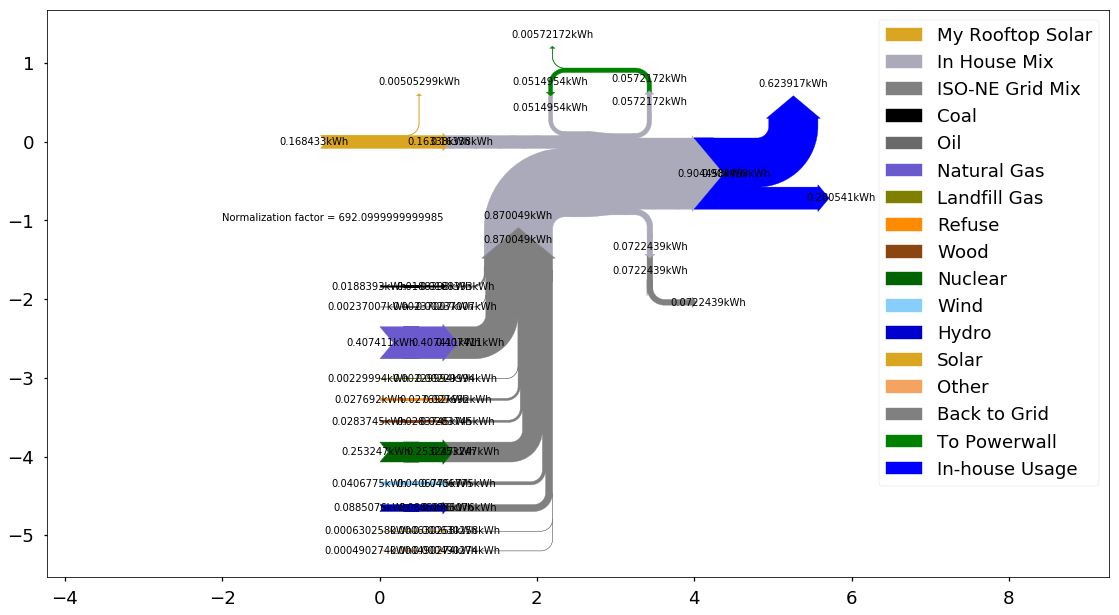

In [91]:
# house sankey diagram - slide 6
sns.set_context('talk', font_scale=1.4)

colors = {'solar':'#DAA520',
          'coal':'#000000',
          'natural_gas': 'slateblue',
          'nuclear': 'darkgreen',
          'hydro': 'mediumblue',
          'landfill_gas': 'olive',
          'refuse': 'darkorange',
          'wind': 'lightskyblue',
          'wood': 'saddlebrown',
          'oil': 'dimgray',
          'other': 'sandybrown',
          'iso_mix': 'gray',
          'house_mix':'#AAAABB'}
house_mix_color = '#733900'
hatch_width = 3.0
default_path_length = 0.5
mpl.rcParams['hatch.linewidth'] = hatch_width  
in_home_trunk_length = 1.2
reference_plot = True

month_oi, year_oi = 11, 2018
subset_df = master_df[(master_df['year']==year_oi)&(master_df['month']==month_oi)].copy()
month_model_exes = list(subset_df[['Dry-bulb (F)', 'dayofmonth']].groupby('dayofmonth').agg(np.mean)['Dry-bulb (F)'])

subset_df['Sum_of_all_fuels'] = subset_df[['Coal',
 'Natural Gas',
 'Nuclear',
 'Hydro',
 'Landfill Gas',
 'Refuse',
 'Solar',
 'Wind',
 'Wood',
 'Oil',
 'Other']].sum(axis=1)

for fuel in ['Coal',
 'Natural Gas',
 'Nuclear',
 'Hydro',
 'Landfill Gas',
 'Refuse',
 'Solar',
 'Wind',
 'Wood',
 'Oil',
 'Other']:
    subset_df[f'{fuel}_frac'] = subset_df[fuel] / subset_df['Sum_of_all_fuels']
    subset_df[f'{fuel}_kWh_personal'] = subset_df['N01_kWh'] * subset_df[f'{fuel}_frac']
    
sum_energy = subset_df[['Coal_kWh_personal',
 'Natural Gas_kWh_personal',
 'Nuclear_kWh_personal',
 'Hydro_kWh_personal',
 'Landfill Gas_kWh_personal',
 'Refuse_kWh_personal',
 'Solar_kWh_personal',
 'Wind_kWh_personal',
 'Wood_kWh_personal',
 'Oil_kWh_personal',
 'Other_kWh_personal', 
 'N01_kWh', 
 'NGEN_kWh', 
 'produced_Wh',
 'solaredge_kW']].sum(axis=0)
sum_energy['produced_kWh'] = sum_energy['produced_Wh'] / 1000.0

fig, ax = plt.subplots(figsize=(16,9))
norm_factor = 1.0 * (sum_energy['N01_kWh'] + sum_energy['NGEN_kWh'])
norm_energy = sum_energy / norm_factor
#norm_energy['produced_kWh'] = norm_energy['solaredge_kW'] / 1000.0
norm_energy['inverter_losses'] = norm_energy['produced_kWh'] * 0.03
norm_energy['post_inverter_production'] = norm_energy['produced_kWh'] - norm_energy['inverter_losses']

to_powerwall = len(subset_df[subset_df['powerwall_discharge']==1]['dayofmonth'].unique())*13.2  / norm_factor
powerwall_losses = to_powerwall*0.1 
powerwall_returns = to_powerwall*0.9 

if reference_plot:
    unit='kWh'
    ax.text(x=-2, y=-1, s=f'Normalization factor = {norm_factor}', fontsize=10)
else:
    unit=None
sankey = Sankey(ax=ax, unit=unit, radius=0.15)
# sankey 0
sankey.add(flows=[norm_energy['produced_kWh'],
                  -norm_energy['post_inverter_production'], 
                  -norm_energy['inverter_losses']], 
           label='My Rooftop Solar',
           trunklength=1,
           orientations=[0, 0, 1],
           pathlengths=[0.5,0.3,0.5],
           facecolor=colors['solar'],
           edgecolor=colors['solar']
          )
# sankey 1
sankey.add(flows=[norm_energy['post_inverter_production'], 
                  norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                       'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal',
                                       'Hydro_kWh_personal', 'Solar_kWh_personal']].sum(), 
                  -(norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh'])),
                  -(norm_energy['NGEN_kWh']-to_powerwall),
                  -to_powerwall,
                  powerwall_returns],
          label='In House Mix',
          trunklength=in_home_trunk_length,
          orientations=[0,-1,0,-1,1,1],
          pathlengths=[0.5,0.5, 0.5, 0.5, 0.5, 0.5],
          facecolor=colors['house_mix'],
          edgecolor=colors['house_mix'],
          hatch='/',
          prior=0,
          connect=(1, 0))
# sankey 2
sankey.add(flows=[norm_energy['Coal_kWh_personal'],
                  norm_energy['Oil_kWh_personal'],
                  norm_energy['Natural Gas_kWh_personal'],
                  norm_energy['Landfill Gas_kWh_personal'],
                  norm_energy['Refuse_kWh_personal'],
                  norm_energy['Wood_kWh_personal'],
                  norm_energy['Nuclear_kWh_personal'],
                  norm_energy['Wind_kWh_personal'],
                  norm_energy['Hydro_kWh_personal'],
                  norm_energy['Solar_kWh_personal'],
                  norm_energy['Other_kWh_personal'],
                  -norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                       'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal',
                                       'Hydro_kWh_personal', 'Solar_kWh_personal']].sum()],
          label='ISO-NE Grid Mix',
          trunklength=0.3,
          orientations=[1,1,1,1,1,1,1,1,1,1,1,0],
          pathlengths=[default_path_length,
                       default_path_length+norm_energy['Coal_kWh_personal'],
                       default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal']].sum(),
                       default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal']].sum(),
                       default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal']].sum(),
                       default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                       'Refuse_kWh_personal']].sum(),
                       default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                       'Refuse_kWh_personal', 'Wood_kWh_personal']].sum(),
                       default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                       'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal']].sum(),
                       default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                       'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal']].sum(),
                       default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                       'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal',
                                       'Hydro_kWh_personal']].sum(),
                       default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                       'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal',
                                       'Hydro_kWh_personal', 'Solar_kWh_personal']].sum(),
                       0.3],
          facecolor=colors['iso_mix'],
          edgecolor=colors['iso_mix'],
          prior=1,
          connect=(1, 11))
# sankey 3
sankey.add(flows=[norm_energy['Coal_kWh_personal'], 
                  -norm_energy['Coal_kWh_personal']],
          label='Coal',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['coal'],
          edgecolor=colors['coal'],
          prior=2,
          connect=(0,1))
# sankey 4
sankey.add(flows=[norm_energy['Oil_kWh_personal'], 
                  -norm_energy['Oil_kWh_personal']],
          label='Oil',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['oil'],
          edgecolor=colors['oil'],
          prior=2,
          connect=(1,1))

# sankey 5
sankey.add(flows=[norm_energy['Natural Gas_kWh_personal'], 
                  -norm_energy['Natural Gas_kWh_personal']],
          label='Natural Gas',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['natural_gas'],
          edgecolor=colors['natural_gas'],
          prior=2,
          connect=(2,1))
# sankey 6
sankey.add(flows=[norm_energy['Landfill Gas_kWh_personal'], 
                  -norm_energy['Landfill Gas_kWh_personal']],
          label='Landfill Gas',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['landfill_gas'],
          edgecolor=colors['landfill_gas'],
          prior=2,
          connect=(3,1))
# sankey 7
sankey.add(flows=[norm_energy['Refuse_kWh_personal'], 
                  -norm_energy['Refuse_kWh_personal']],
          label='Refuse',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['refuse'],
          edgecolor=colors['refuse'],
          prior=2,
          connect=(4,1))
# sankey 8
sankey.add(flows=[norm_energy['Wood_kWh_personal'], 
                  -norm_energy['Wood_kWh_personal']],
          label='Wood',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['wood'],
          edgecolor=colors['wood'],
          prior=2,
          connect=(5,1))
# sankey 9
sankey.add(flows=[norm_energy['Nuclear_kWh_personal'], 
                  -norm_energy['Nuclear_kWh_personal']],
          label='Nuclear',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['nuclear'],
          edgecolor=colors['nuclear'],
          prior=2,
          connect=(6,1))
# sankey 10
sankey.add(flows=[norm_energy['Wind_kWh_personal'], 
                  -norm_energy['Wind_kWh_personal']],
          label='Wind',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['wind'],
          edgecolor=colors['wind'],
          prior=2,
          connect=(7,1))
# sankey 11
sankey.add(flows=[norm_energy['Hydro_kWh_personal'], 
                  -norm_energy['Hydro_kWh_personal']],
          label='Hydro',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['hydro'],
          edgecolor=colors['hydro'],
          prior=2,
          connect=(8,1))
# sankey 12
sankey.add(flows=[norm_energy['Solar_kWh_personal'], 
                  -norm_energy['Solar_kWh_personal']],
          label='Solar',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['solar'],
          edgecolor=colors['solar'],
          prior=2,
          connect=(9,1))
# sankey 13
sankey.add(flows=[norm_energy['Other_kWh_personal'], 
                  -norm_energy['Other_kWh_personal']],
          label='Other',
          trunklength=0.3,
          orientations=[0,0],
          pathlengths=[0.5, 0.5],
          facecolor=colors['other'],
          edgecolor=colors['other'],
          prior=2,
          connect=(10,1))
# sankey 14
sankey.add(flows=[(norm_energy['NGEN_kWh']-to_powerwall), 
                  -(norm_energy['NGEN_kWh']-to_powerwall)],
          label='Back to Grid',
          trunklength=0.3,
          orientations=[0,1],
          pathlengths=[0.5, 0.5],
          facecolor='gray',
          edgecolor='gray',
          prior=1,
          connect=(3,0))
# sankey 15 - powerwall sankey
sankey.add(flows=[to_powerwall, -powerwall_losses, -powerwall_returns],
          label='To Powerwall',
          orientations=[1,-1, 1],
          trunklength=in_home_trunk_length,
          facecolor='green',
          edgecolor='green',
          prior=1,
          connect=(4, 0))

days_in_month = len(month_model_exes)

total_energy = np.nansum([five_parameter_model(x, coeff_2018[0], coeff_2018[1], 
                                      coeff_2018[2], coeff_2018[3], coeff_2018[4]) for x in month_model_exes])
baseline_usage = (coeff_2018[2] + coeff_2018[3] * coeff_2018[0]) * days_in_month
baseline_ratio = baseline_usage / total_energy
print(total_energy, baseline_ratio, baseline_usage)

# sankey 16 - climate control
sankey.add(flows=[(norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh'])), 
                  -(1-baseline_ratio) * (norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh'])),
                  -baseline_ratio*(norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh']))],
          label='In-house Usage',
          orientations=[0, 1, 0],
          trunklength=in_home_trunk_length,
          facecolor='blue',
          edgecolor='blue',
          prior=1,
          connect=(2, 0))


#sankey.add(flows=[-.25, 0.15, 0.1], label='two',
#           orientations=[0, 1, -1], prior=0, connect=(0, 0))
diagrams = sankey.finish()
for d in diagrams:
    for t in d.texts:
        t.set_horizontalalignment('center')
        t.set_fontsize(10)
plt.tight_layout()

if reference_plot == True:
    plt.legend()
    filename_adder = '_ref'
else:
    filename_adder = ''
fig.savefig(f'sankey{month_oi}{filename_adder}.png', dpi=300)

199.7097894628027 0.8353326474139462 166.8241071464448
261.5876088949628 0.6589949403421932 172.38491071799297
216.61818350463074 0.795800739942535 172.38491071799297
228.99714805930165 0.7284986234992046 166.8241071464448
386.62255339856233 0.4458739129485921 172.38491071799297
537.8380191300732 0.31017537104623927 166.8241071464448
608.4874901442168 0.2833006651905633 172.38491071799297


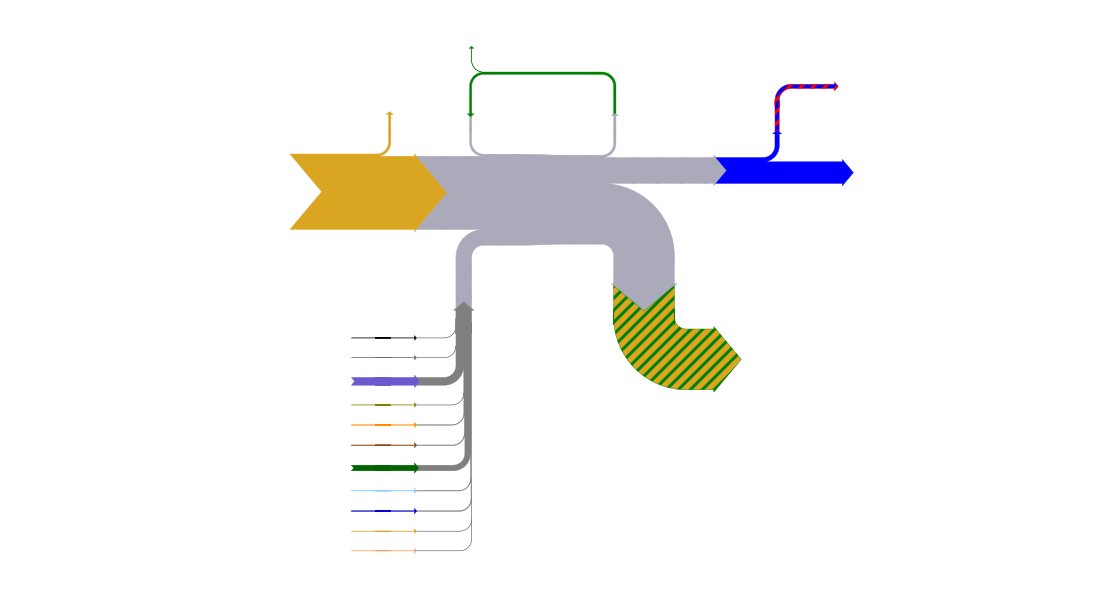

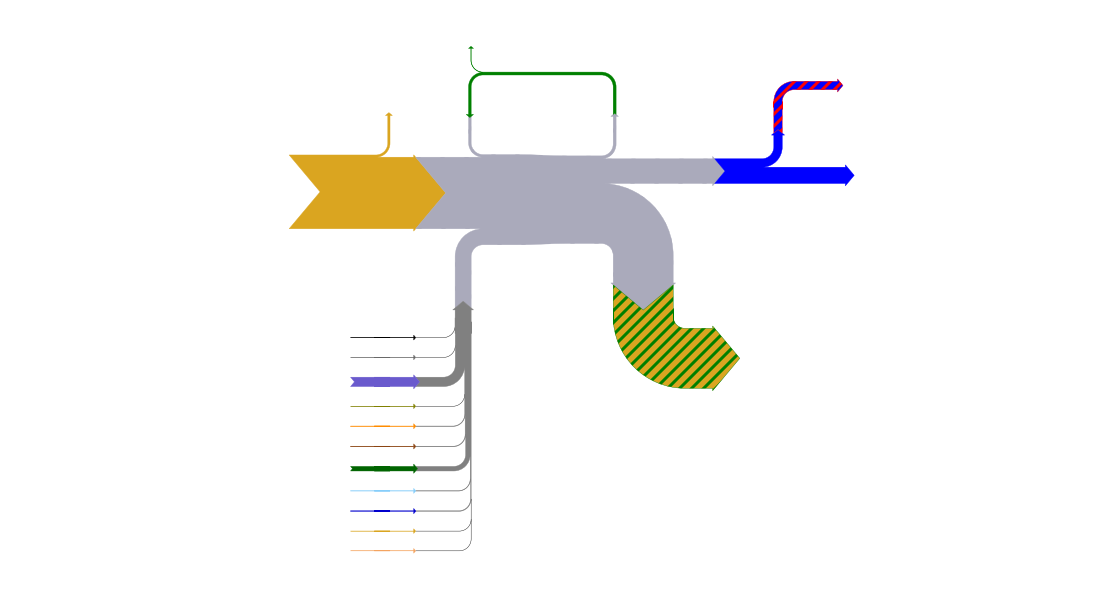

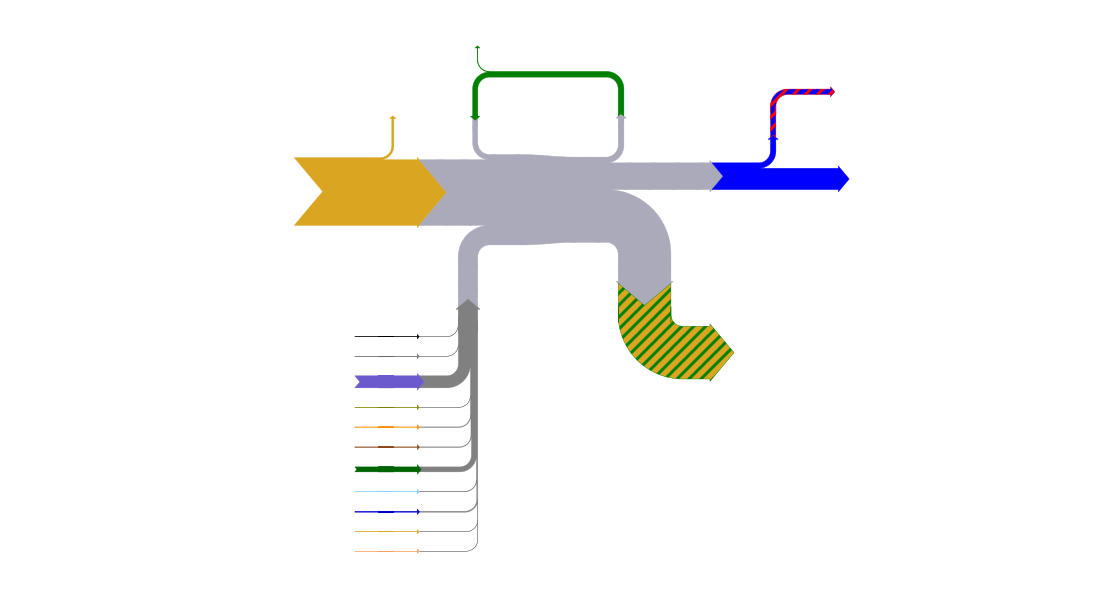

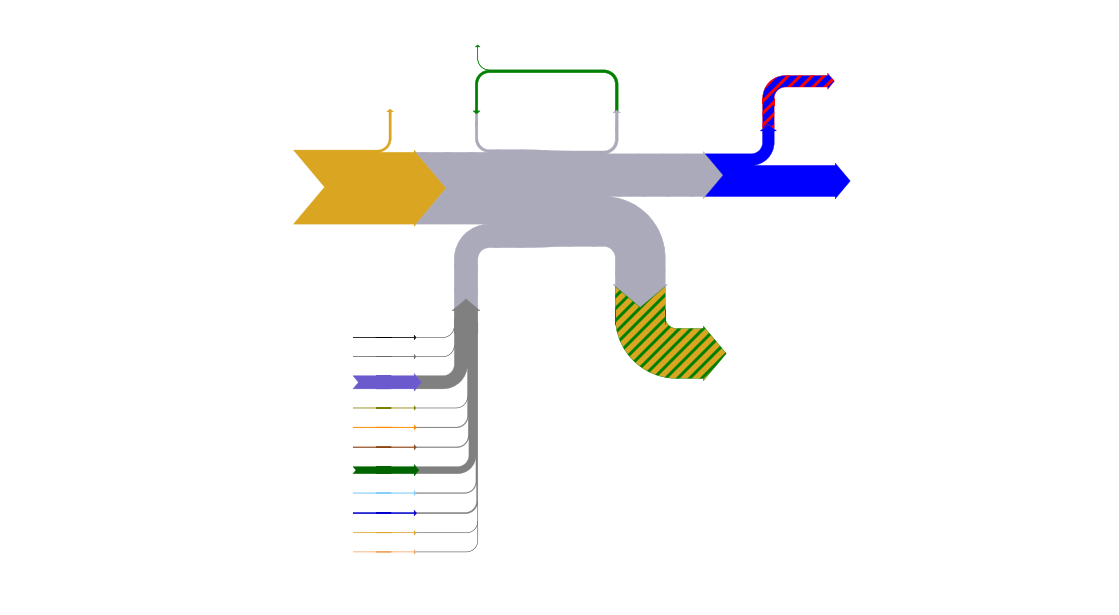

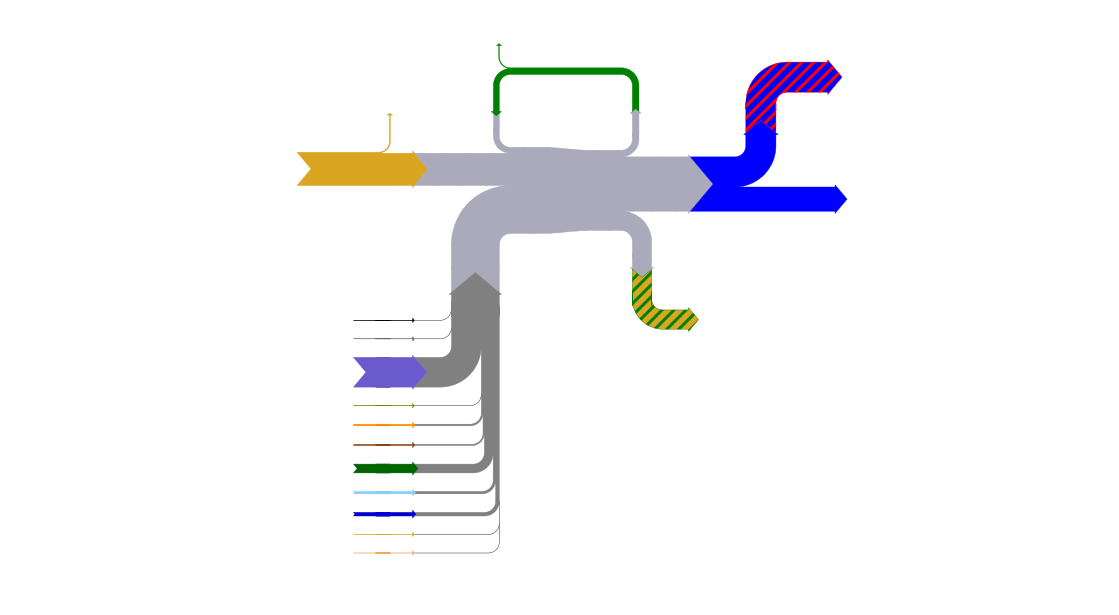

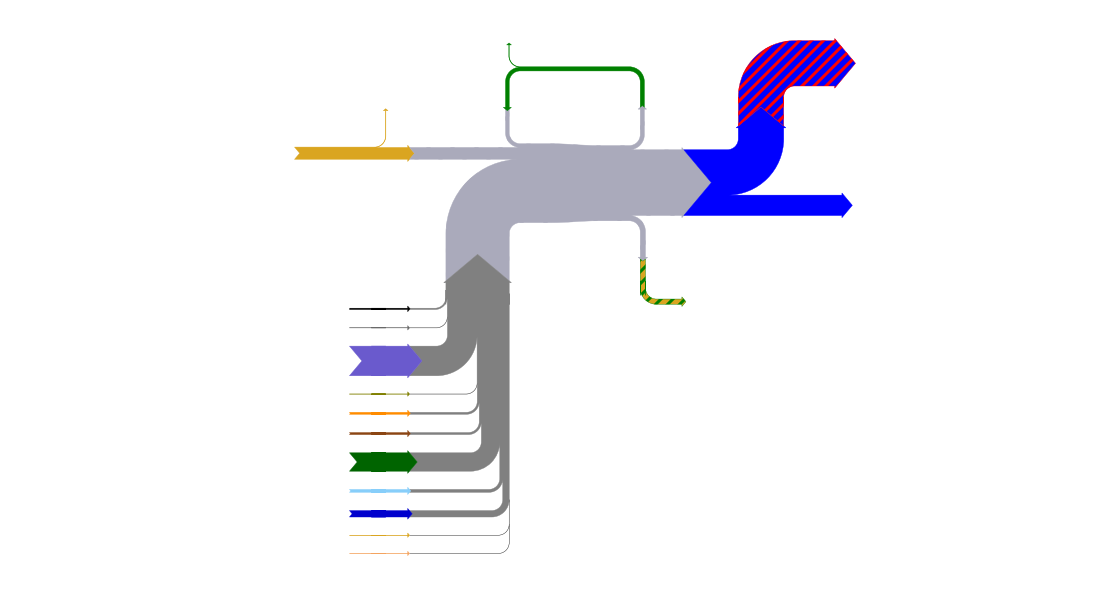

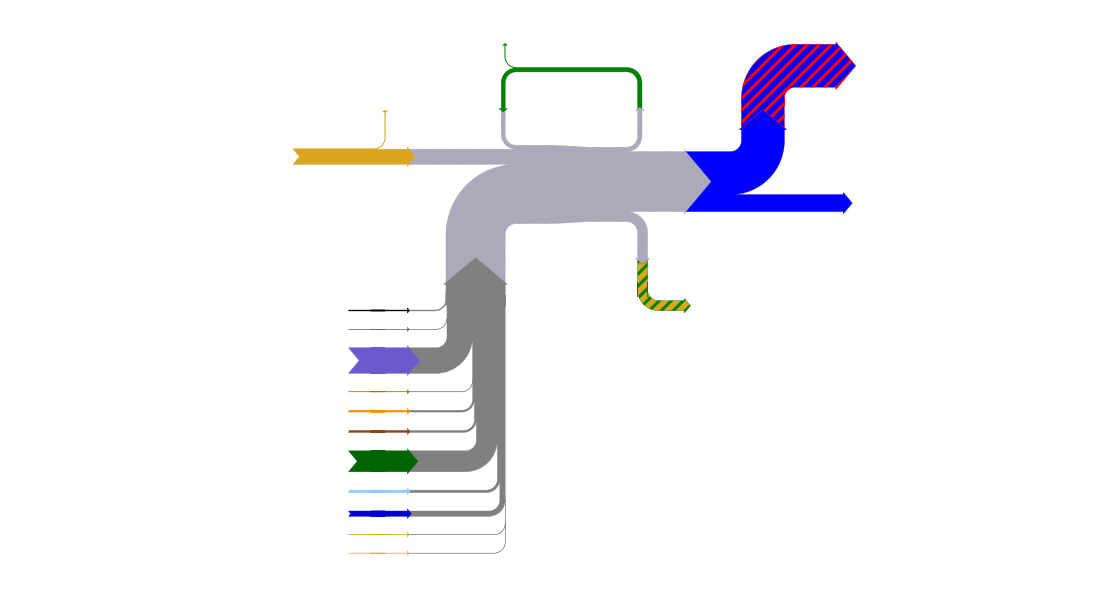

In [267]:
for month_oi in np.arange(6,13):
    # house sankey diagram - slide 6
    sns.set_context('talk', font_scale=1.4)

    colors = {'solar':'#DAA520',
              'coal':'#000000',
              'natural_gas': 'slateblue',
              'nuclear': 'darkgreen',
              'hydro': 'mediumblue',
              'landfill_gas': 'olive',
              'refuse': 'darkorange',
              'wind': 'lightskyblue',
              'wood': 'saddlebrown',
              'oil': 'dimgray',
              'other': 'sandybrown',
              'iso_mix': 'gray',
              'house_mix':'#AAAABB'}
    house_mix_color = '#733900'
    hatch_width = 3.0
    default_path_length = 0.5
    mpl.rcParams['hatch.linewidth'] = hatch_width  
    in_home_trunk_length = 1.8
    reference_plot = False

    year_oi = 2018
    subset_df = master_df[(master_df['year']==year_oi)&(master_df['month']==month_oi)].copy()
    month_model_exes = list(subset_df[['Dry-bulb (F)', 'dayofmonth']].groupby('dayofmonth').agg(np.mean)['Dry-bulb (F)'])

    subset_df['Sum_of_all_fuels'] = subset_df[['Coal',
     'Natural Gas',
     'Nuclear',
     'Hydro',
     'Landfill Gas',
     'Refuse',
     'Solar',
     'Wind',
     'Wood',
     'Oil',
     'Other']].sum(axis=1)

    for fuel in ['Coal',
     'Natural Gas',
     'Nuclear',
     'Hydro',
     'Landfill Gas',
     'Refuse',
     'Solar',
     'Wind',
     'Wood',
     'Oil',
     'Other']:
        subset_df[f'{fuel}_frac'] = subset_df[fuel] / subset_df['Sum_of_all_fuels']
        subset_df[f'{fuel}_kWh_personal'] = subset_df['N01_kWh'] * subset_df[f'{fuel}_frac']

    sum_energy = subset_df[['Coal_kWh_personal',
     'Natural Gas_kWh_personal',
     'Nuclear_kWh_personal',
     'Hydro_kWh_personal',
     'Landfill Gas_kWh_personal',
     'Refuse_kWh_personal',
     'Solar_kWh_personal',
     'Wind_kWh_personal',
     'Wood_kWh_personal',
     'Oil_kWh_personal',
     'Other_kWh_personal', 
     'N01_kWh', 
     'NGEN_kWh', 
     'produced_Wh',
     'solaredge_kW']].sum(axis=0)
    sum_energy['produced_kWh'] = sum_energy['produced_Wh'] / 1000.0

    fig, ax = plt.subplots(figsize=(16,9))
    
    norm_factor = 1.0 * (sum_energy['N01_kWh'] + sum_energy['NGEN_kWh'])
    norm_energy = sum_energy / norm_factor
    #norm_energy['produced_kWh'] = norm_energy['solaredge_kW'] / 1000.0
    norm_energy['inverter_losses'] = norm_energy['produced_kWh'] * 0.03
    norm_energy['post_inverter_production'] = norm_energy['produced_kWh'] - norm_energy['inverter_losses']

    to_powerwall = len(subset_df[subset_df['powerwall_discharge']==1]['dayofmonth'].unique())*13.2  / norm_factor
    powerwall_losses = to_powerwall*0.1 
    powerwall_returns = to_powerwall*0.9 

    if reference_plot:
        unit='kWh'
        ax.text(x=-2, y=-1, s=f'Normalization factor = {norm_factor}', fontsize=10)
    else:
        unit=None
        #ax.text(x=-1, y=1, s=f'{FULL_MONTH_NAMES[month_oi-1]}', fontsize=24)
    sankey = Sankey(ax=ax, unit=unit, radius=0.15)
    # sankey 0
    sankey.add(flows=[norm_energy['produced_kWh'],
                      -norm_energy['post_inverter_production'], 
                      -norm_energy['inverter_losses']], 
               label='My Rooftop Solar',
               trunklength=1,
               orientations=[0, 0, 1],
               pathlengths=[0.5,0.3,0.5],
               facecolor=colors['solar'],
               edgecolor=colors['solar']
              )
    # sankey 1
    sankey.add(flows=[norm_energy['post_inverter_production'], 
                      norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                           'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal',
                                           'Hydro_kWh_personal', 'Solar_kWh_personal']].sum(), 
                      -(norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh'])),
                      -(norm_energy['NGEN_kWh']-to_powerwall),
                      -to_powerwall,
                      powerwall_returns],
              label='In House Mix',
              trunklength=in_home_trunk_length,
              orientations=[0,-1,0,-1,1,1],
              pathlengths=[0.5,0.8, 0.5, 0.5, 0.5, 0.5],
              facecolor=colors['house_mix'],
              edgecolor=colors['house_mix'],
              hatch='/',
              prior=0,
              connect=(1, 0))
    # sankey 2
    sankey.add(flows=[norm_energy['Coal_kWh_personal'],
                      norm_energy['Oil_kWh_personal'],
                      norm_energy['Natural Gas_kWh_personal'],
                      norm_energy['Landfill Gas_kWh_personal'],
                      norm_energy['Refuse_kWh_personal'],
                      norm_energy['Wood_kWh_personal'],
                      norm_energy['Nuclear_kWh_personal'],
                      norm_energy['Wind_kWh_personal'],
                      norm_energy['Hydro_kWh_personal'],
                      norm_energy['Solar_kWh_personal'],
                      norm_energy['Other_kWh_personal'],
                      -norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                           'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal',
                                           'Hydro_kWh_personal', 'Solar_kWh_personal']].sum()],
              label='ISO-NE Grid Mix',
              trunklength=0.3,
              orientations=[1,1,1,1,1,1,1,1,1,1,1,0],
              pathlengths=[default_path_length,
                           default_path_length+norm_energy['Coal_kWh_personal'],
                           default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal']].sum(),
                           default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal']].sum(),
                           default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal']].sum(),
                           default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                           'Refuse_kWh_personal']].sum(),
                           default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                           'Refuse_kWh_personal', 'Wood_kWh_personal']].sum(),
                           default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                           'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal']].sum(),
                           default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                           'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal']].sum(),
                           default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                           'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal',
                                           'Hydro_kWh_personal']].sum(),
                           default_path_length+norm_energy[['Oil_kWh_personal', 'Coal_kWh_personal', 'Natural Gas_kWh_personal', 'Landfill Gas_kWh_personal',
                                           'Refuse_kWh_personal', 'Wood_kWh_personal', 'Nuclear_kWh_personal', 'Wind_kWh_personal',
                                           'Hydro_kWh_personal', 'Solar_kWh_personal']].sum(),
                           0.3],
              facecolor=colors['iso_mix'],
              edgecolor=colors['iso_mix'],
              prior=1,
              connect=(1, 11))
    # sankey 3
    sankey.add(flows=[norm_energy['Coal_kWh_personal'], 
                      -norm_energy['Coal_kWh_personal']],
              label='Coal',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['coal'],
              edgecolor=colors['coal'],
              prior=2,
              connect=(0,1))
    # sankey 4
    sankey.add(flows=[norm_energy['Oil_kWh_personal'], 
                      -norm_energy['Oil_kWh_personal']],
              label='Oil',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['oil'],
              edgecolor=colors['oil'],
              prior=2,
              connect=(1,1))

    # sankey 5
    sankey.add(flows=[norm_energy['Natural Gas_kWh_personal'], 
                      -norm_energy['Natural Gas_kWh_personal']],
              label='Natural Gas',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['natural_gas'],
              edgecolor=colors['natural_gas'],
              prior=2,
              connect=(2,1))
    # sankey 6
    sankey.add(flows=[norm_energy['Landfill Gas_kWh_personal'], 
                      -norm_energy['Landfill Gas_kWh_personal']],
              label='Landfill Gas',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['landfill_gas'],
              edgecolor=colors['landfill_gas'],
              prior=2,
              connect=(3,1))
    # sankey 7
    sankey.add(flows=[norm_energy['Refuse_kWh_personal'], 
                      -norm_energy['Refuse_kWh_personal']],
              label='Refuse',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['refuse'],
              edgecolor=colors['refuse'],
              prior=2,
              connect=(4,1))
    # sankey 8
    sankey.add(flows=[norm_energy['Wood_kWh_personal'], 
                      -norm_energy['Wood_kWh_personal']],
              label='Wood',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['wood'],
              edgecolor=colors['wood'],
              prior=2,
              connect=(5,1))
    # sankey 9
    sankey.add(flows=[norm_energy['Nuclear_kWh_personal'], 
                      -norm_energy['Nuclear_kWh_personal']],
              label='Nuclear',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['nuclear'],
              edgecolor=colors['nuclear'],
              prior=2,
              connect=(6,1))
    # sankey 10
    sankey.add(flows=[norm_energy['Wind_kWh_personal'], 
                      -norm_energy['Wind_kWh_personal']],
              label='Wind',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['wind'],
              edgecolor=colors['wind'],
              prior=2,
              connect=(7,1))
    # sankey 11
    sankey.add(flows=[norm_energy['Hydro_kWh_personal'], 
                      -norm_energy['Hydro_kWh_personal']],
              label='Hydro',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['hydro'],
              edgecolor=colors['hydro'],
              prior=2,
              connect=(8,1))
    # sankey 12
    sankey.add(flows=[norm_energy['Solar_kWh_personal'], 
                      -norm_energy['Solar_kWh_personal']],
              label='Solar',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['solar'],
              edgecolor=colors['solar'],
              prior=2,
              connect=(9,1))
    # sankey 13
    sankey.add(flows=[norm_energy['Other_kWh_personal'], 
                      -norm_energy['Other_kWh_personal']],
              label='Other',
              trunklength=0.3,
              orientations=[0,0],
              pathlengths=[0.5, 0.5],
              facecolor=colors['other'],
              edgecolor=colors['other'],
              prior=2,
              connect=(10,1))
    # sankey 14
    sankey.add(flows=[(norm_energy['NGEN_kWh']-to_powerwall), 
                      -(norm_energy['NGEN_kWh']-to_powerwall)],
              label='Back to Grid',
              trunklength=0.3,
              orientations=[0,1],
              pathlengths=[0.5, 0.5],
              facecolor=colors['solar'],
              edgecolor='green',
              hatch='//',
              prior=1,
              connect=(3,0))
    # sankey 15 - powerwall sankey
    sankey.add(flows=[to_powerwall, -powerwall_losses, -powerwall_returns],
              label='To Powerwall',
              orientations=[1,-1, 1],
              trunklength=in_home_trunk_length,
              pathlengths=[0.5, 0.3, 0.5],
              facecolor='green',
              edgecolor='green',
              prior=1,
              connect=(4, 0))

    days_in_month = len(month_model_exes)

    total_energy = np.nansum([five_parameter_model(x, coeff_2018[0], coeff_2018[1], 
                                          coeff_2018[2], coeff_2018[3], coeff_2018[4]) for x in month_model_exes])
    baseline_usage = (coeff_2018[2] + coeff_2018[3] * coeff_2018[0]) * days_in_month
    baseline_ratio = baseline_usage / total_energy
    print(total_energy, baseline_ratio, baseline_usage)

    # sankey 16 - climate control
    sankey.add(flows=[(norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh'])), 
                      -(1-baseline_ratio) * (norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh'])),
                      -baseline_ratio*(norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh']))],
              label='In-house Usage',
              orientations=[0, 1, 0],
              pathlengths=[0.3, 0.3, 0.8],
              trunklength=0.7,
              facecolor='blue',
              edgecolor='blue',
              prior=1,
              connect=(2, 0))
    
    # sankey 17 - climate control out
    sankey.add(flows=[(1-baseline_ratio) * (norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh'])), 
                      -(1-baseline_ratio) * (norm_energy['N01_kWh']+(norm_energy['post_inverter_production'] - norm_energy['NGEN_kWh']))],
              label='In-house Usage',
              orientations=[0, -1],
              pathlengths=[0.4, 0.7],
              trunklength=0.4,
              facecolor='blue',
              edgecolor='red',
              hatch='//',
              prior=16,
              connect=(1, 0))


    #sankey.add(flows=[-.25, 0.15, 0.1], label='two',
    #           orientations=[0, 1, -1], prior=0, connect=(0, 0))
    diagrams = sankey.finish()
    for d in diagrams:
        for t in d.texts:
            t.set_horizontalalignment('center')
            t.set_fontsize(10)
    plt.tight_layout()

    if reference_plot == True:
        plt.legend()
        filename_adder = '_ref'
    else:
        filename_adder = ''
        ax.axis('off')
    fig.savefig(f'sankey{month_oi}_{filename_adder}.png', dpi=300)

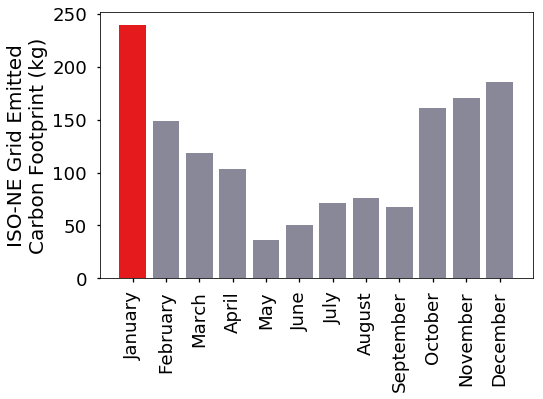

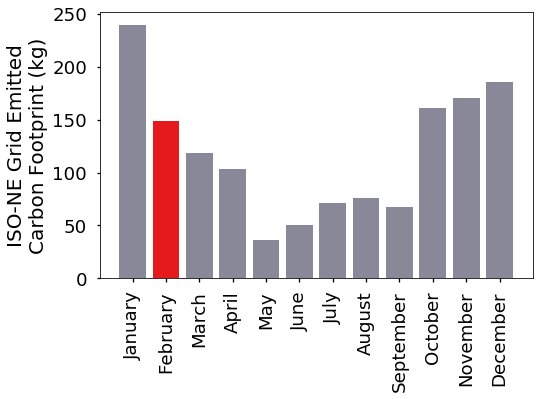

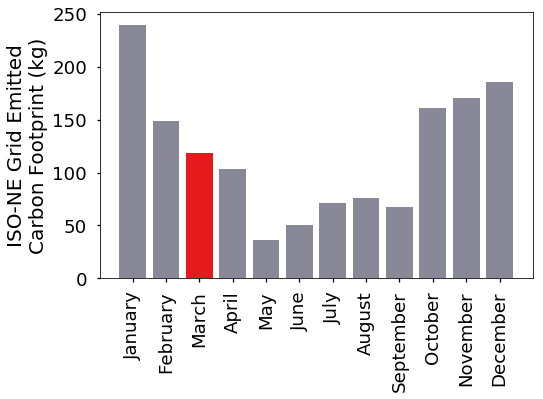

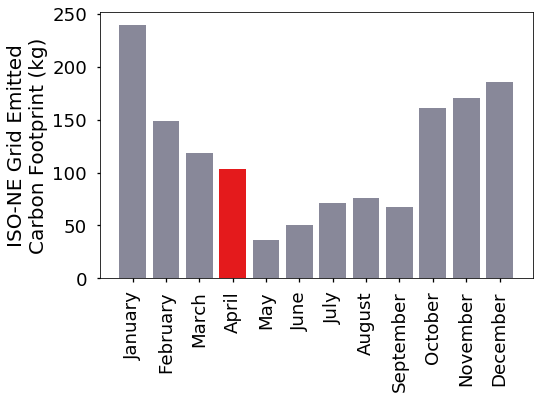

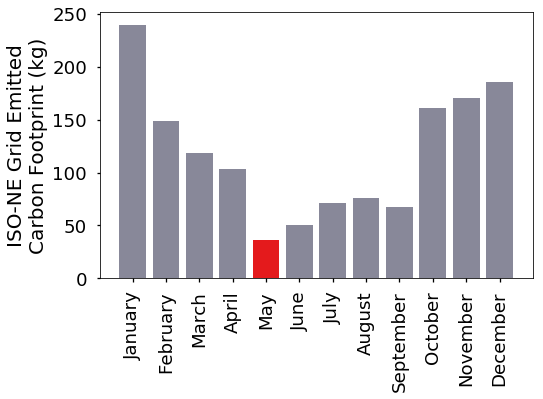

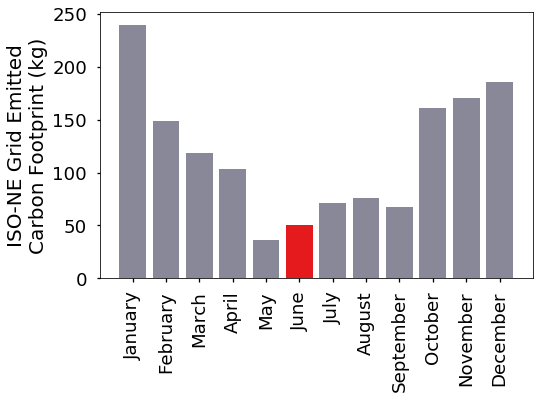

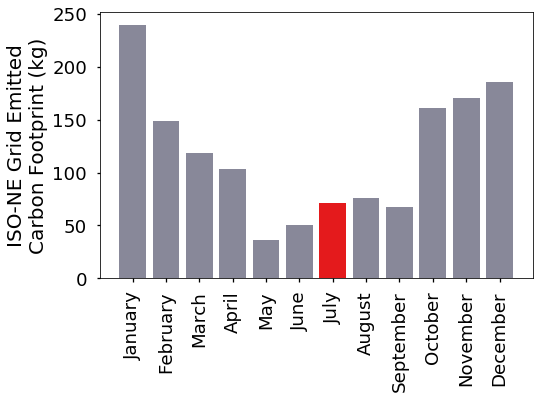

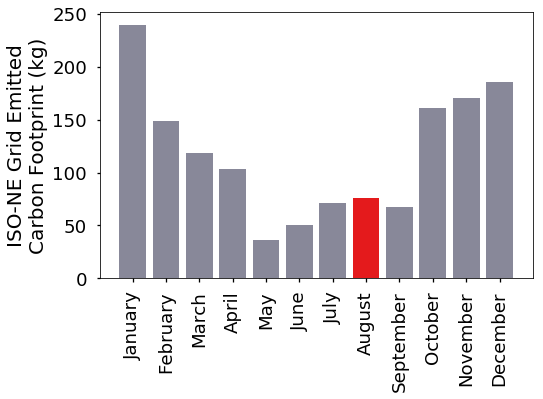

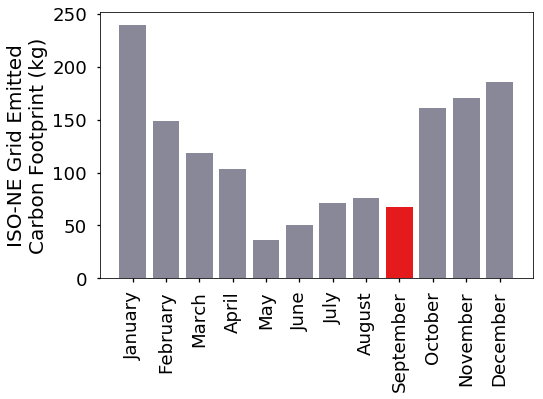

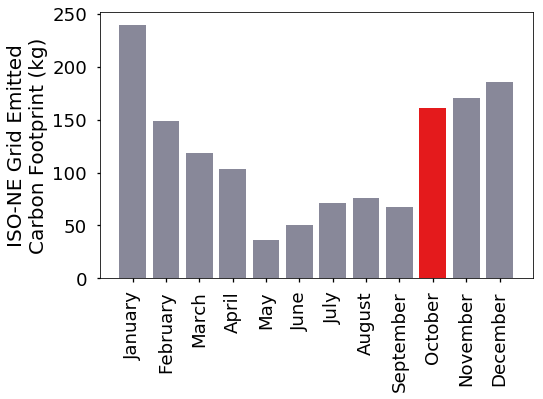

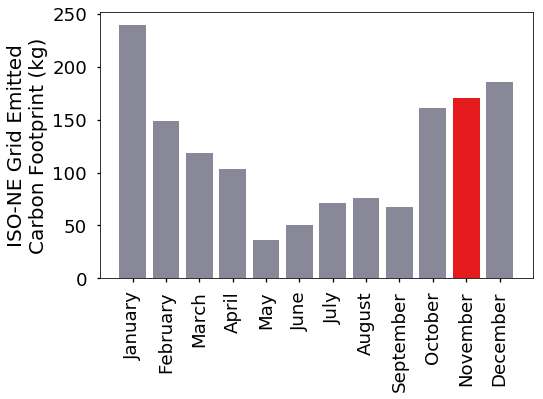

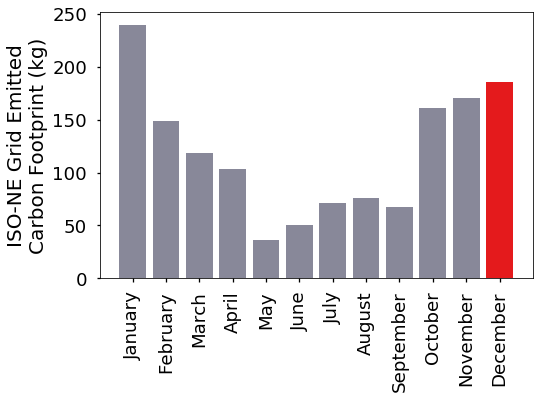

In [216]:
sns.set_context('talk', font_scale=1.4)
carbonsub_df = master_df[['year', 'month', 'carbon_g_per_kWh', 'N01_kWh']].copy()
carbonsub_df['carbon_g'] = carbonsub_df['carbon_g_per_kWh'] * carbonsub_df['N01_kWh']
carbon_gdf = carbonsub_df.groupby(['year', 'month']).agg('sum').reset_index()


moi, yoi = 6, 2018
for moi in np.arange(1,13):
    graph_df = carbon_gdf[carbon_gdf['year']==yoi].copy()
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(graph_df['month'], graph_df['carbon_g'] / 1000.0, color='#888899')
    ax.set_ylabel('ISO-NE Grid Emitted\nCarbon Footprint (kg)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                        'September', 'October', 'November', 'December'], rotation=90)
    highlight_df = graph_df[graph_df['month']==moi].copy()
    ax.bar(highlight_df['month'], highlight_df['carbon_g'] / 1000.0, color=colors[0])
    fig.tight_layout()
    fig.savefig(f'carbon_by_month_{moi}.png', dpi=300)

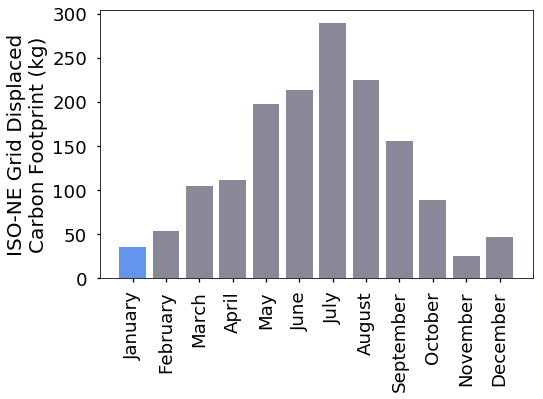

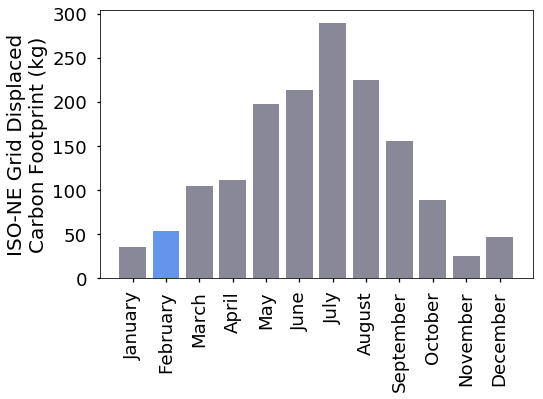

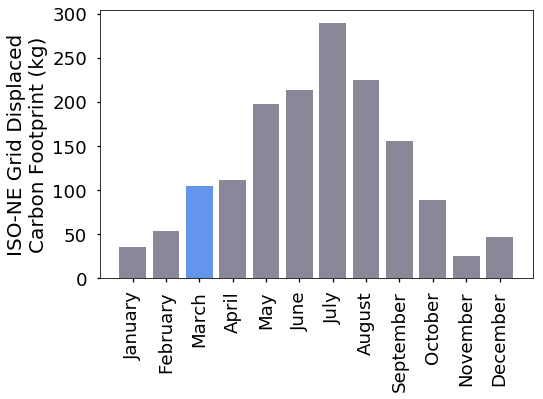

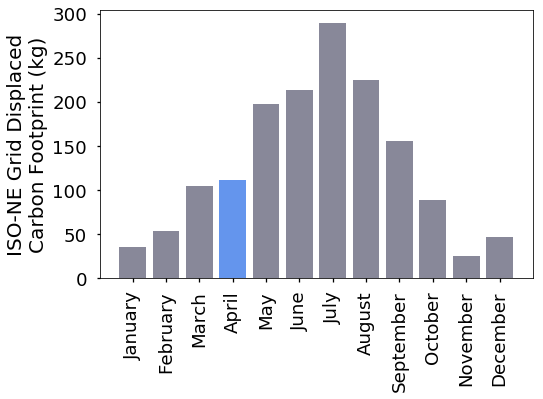

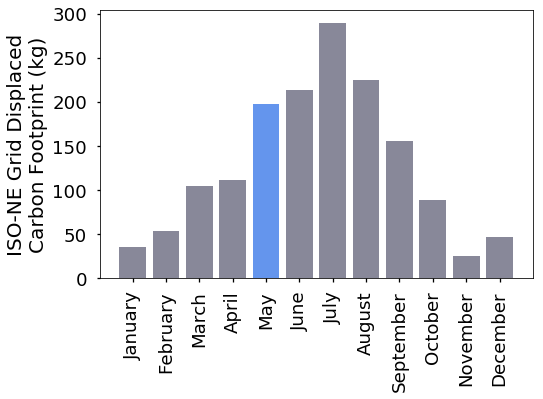

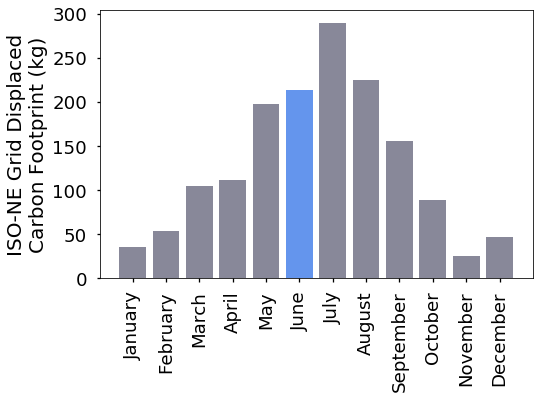

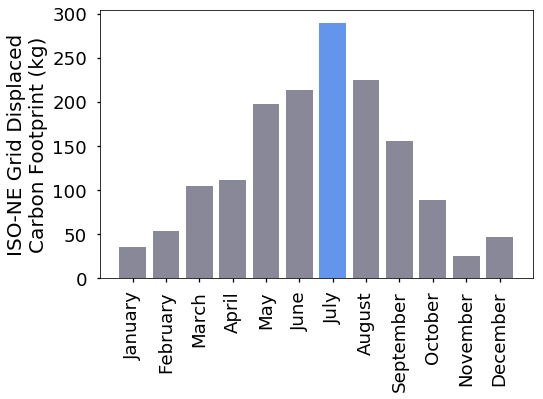

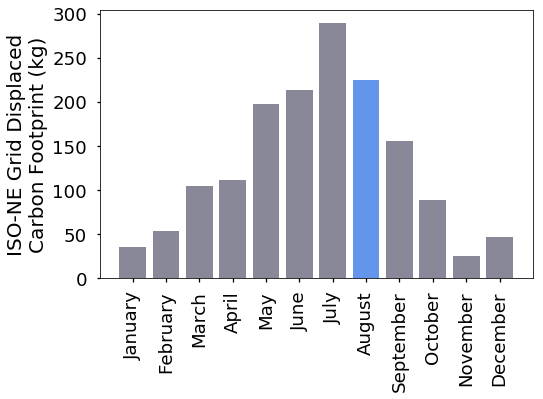

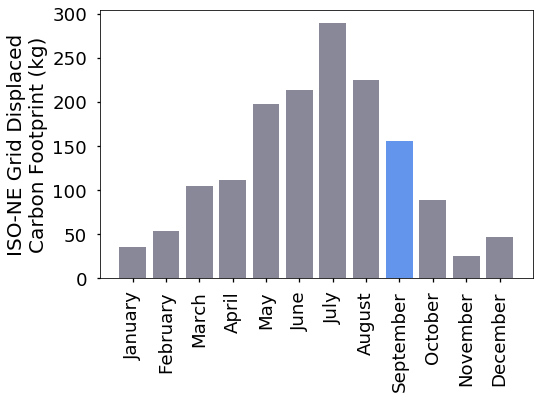

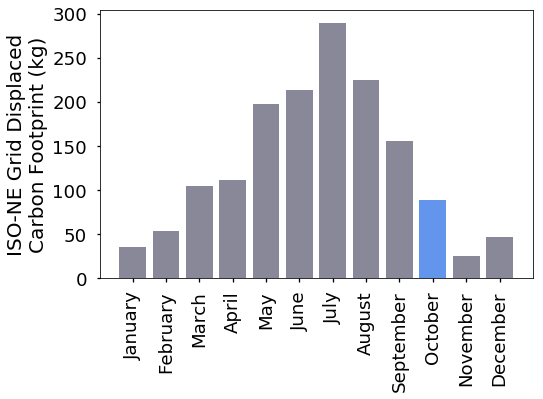

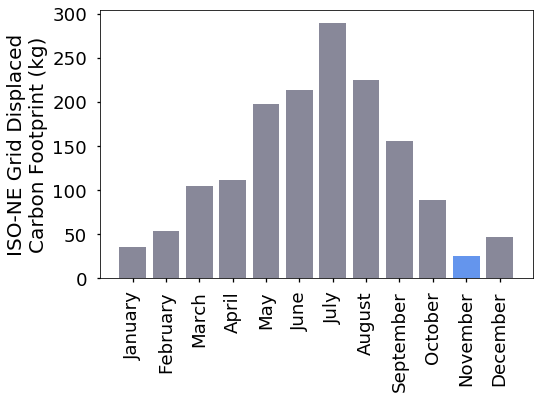

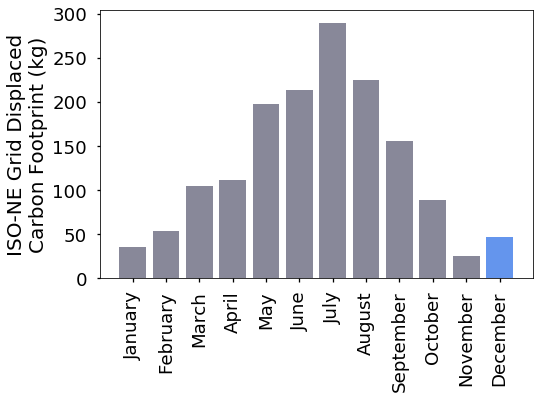

In [218]:
# displaced carbon
sns.set_context('talk', font_scale=1.4)
carbonsub_df = master_df[['year', 'month', 'carbon_g_per_kWh', 'NGEN_kWh']].copy()
carbonsub_df['carbon_g'] = carbonsub_df['carbon_g_per_kWh'] * carbonsub_df['NGEN_kWh']
carbon_gdf = carbonsub_df.groupby(['year', 'month']).agg('sum').reset_index()


moi, yoi = 6, 2018
for moi in np.arange(1,13):
    graph_df = carbon_gdf[carbon_gdf['year']==yoi].copy()
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(graph_df['month'], graph_df['carbon_g'] / 1000.0, color='#888899')
    ax.set_ylabel('ISO-NE Grid Displaced\nCarbon Footprint (kg)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                        'September', 'October', 'November', 'December'], rotation=90)
    highlight_df = graph_df[graph_df['month']==moi].copy()
    ax.bar(highlight_df['month'], highlight_df['carbon_g'] / 1000.0, color='cornflowerblue')
    fig.tight_layout()
    fig.savefig(f'carbon_displaced_by_month_{moi}.png', dpi=300)

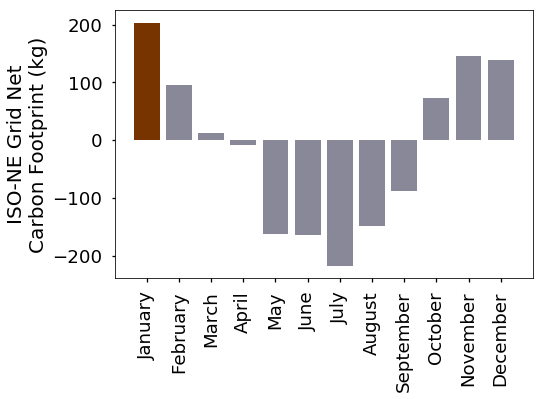

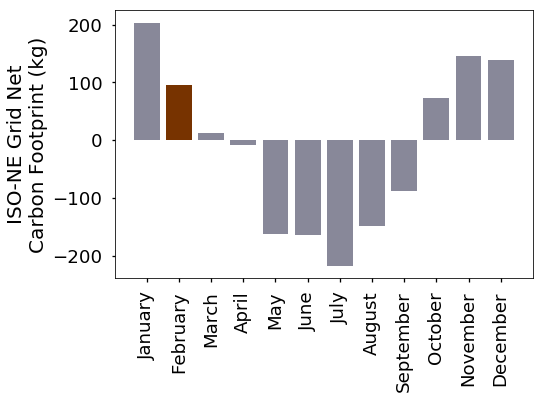

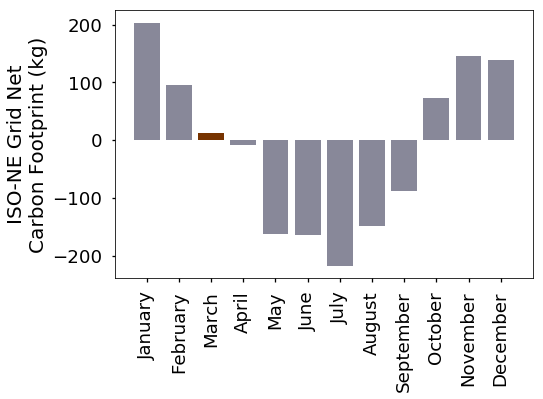

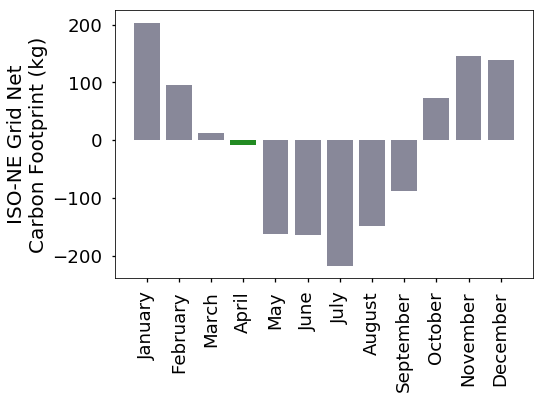

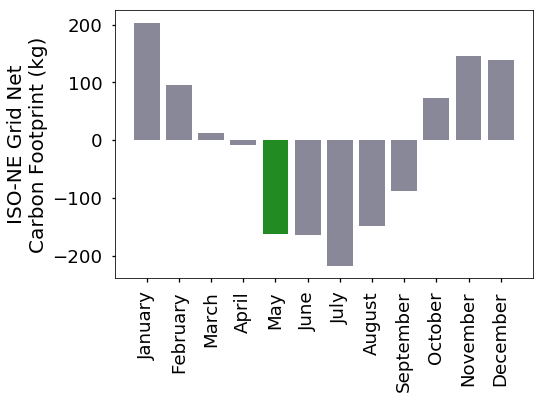

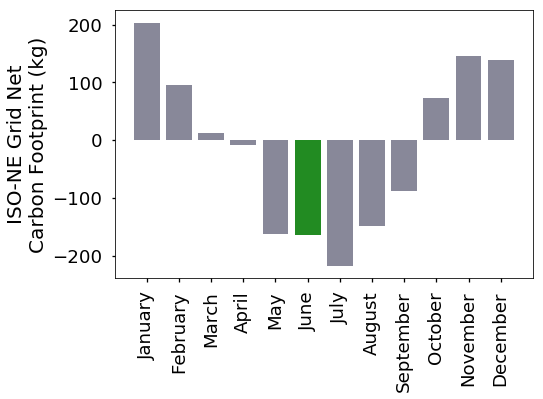

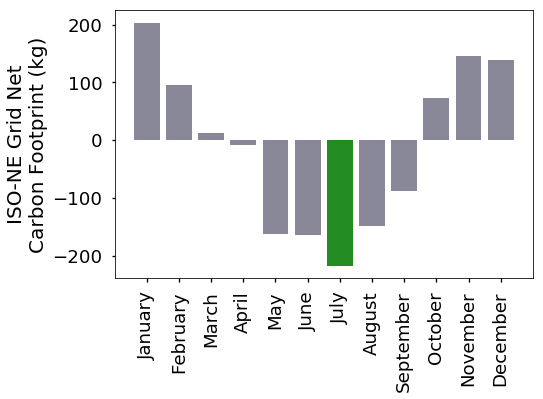

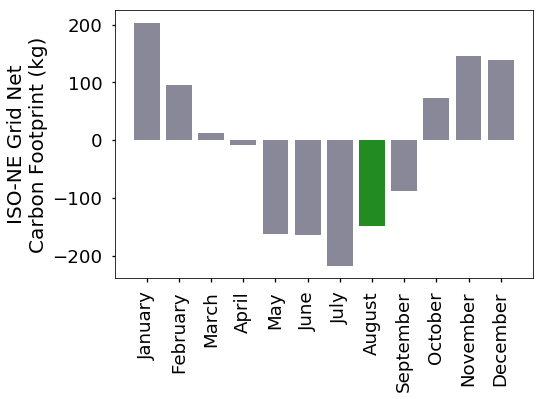

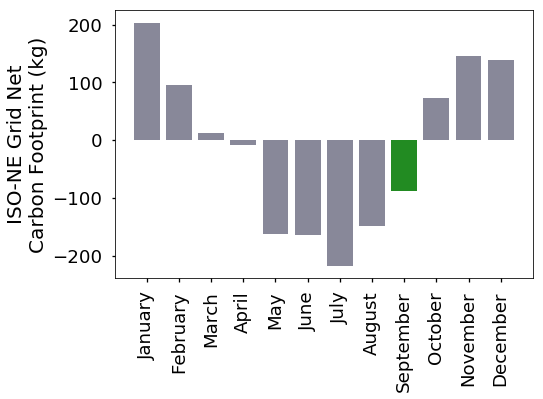

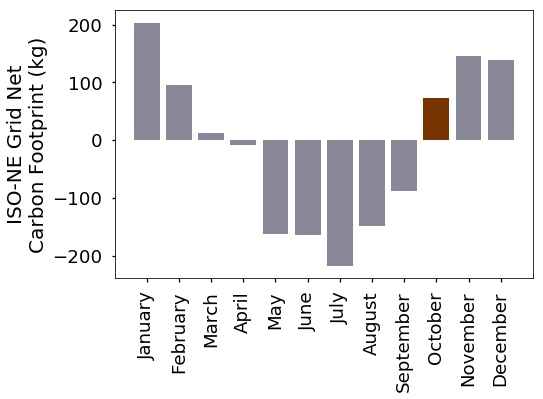

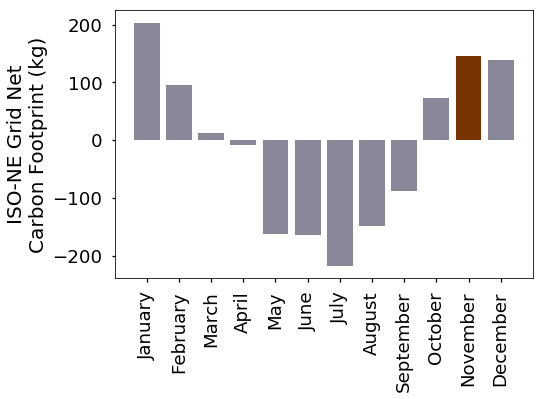

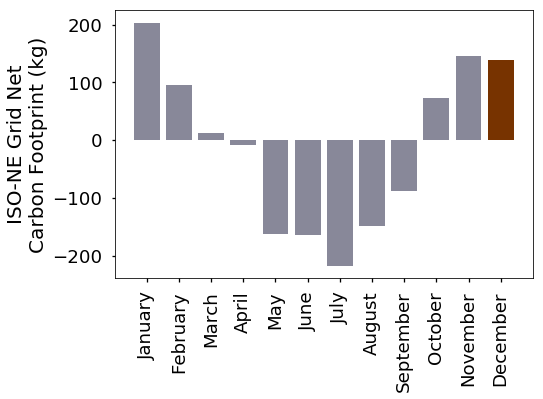

In [224]:
# NET carbon displaced / emissions by 2018 month
# displaced carbon
sns.set_context('talk', font_scale=1.4)
carbonsub_df = master_df[['year', 'month', 'carbon_g_per_kWh', 'NGEN_kWh', 'N01_kWh']].copy()
carbonsub_df['carbon_g_disp'] = carbonsub_df['carbon_g_per_kWh'] * carbonsub_df['NGEN_kWh']
carbonsub_df['carbon_g_emit'] = carbonsub_df['carbon_g_per_kWh'] * carbonsub_df['N01_kWh']
carbonsub_df['net_carbon'] = carbonsub_df['carbon_g_emit'] - carbonsub_df['carbon_g_disp']
carbon_gdf = carbonsub_df.groupby(['year', 'month']).agg('sum').reset_index()


moi, yoi = 6, 2018
for moi in np.arange(1,13):
    graph_df = carbon_gdf[carbon_gdf['year']==yoi].copy()
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(graph_df['month'], graph_df['net_carbon'] / 1000.0, color='#888899')
    ax.set_ylabel('ISO-NE Grid Net\nCarbon Footprint (kg)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                        'September', 'October', 'November', 'December'], rotation=90)
    highlight_df = graph_df[graph_df['month']==moi].copy()
    if highlight_df['net_carbon'].iloc[0] > 0:
        ax.bar(highlight_df['month'], highlight_df['net_carbon'] / 1000.0, color='#773300')
    else:
        ax.bar(highlight_df['month'], highlight_df['net_carbon'] / 1000.0, color='forestgreen')
    fig.tight_layout()
    fig.savefig(f'carbon_net_by_month_{moi}.png', dpi=300)

In [220]:
carbonsub_df.groupby('year').agg(np.sum)

month  carbon_g_per_kWh  NGEN_kWh   N01_kWh  carbon_g_disp  \
year                                                                
2017  228371      1.006858e+07   5344.07  4071.530   1.641773e+06   
2018  228372      9.909660e+06   5175.02  4998.015   1.548561e+06   

      carbon_g_emit     net_carbon  
year                                
2017   1.184897e+06  456876.441304  
2018   1.426631e+06  121930.668558

In [163]:
# slide: TMY3 comparison of 2017 to 2018
tmy3_df = pd.read_csv('../tmy3_data/btv_tmy3.csv')
tmy3_df['dt'] = tmy3_df['Date (MM/DD/YYYY)'].apply(lambda x: pd.to_datetime(x))
tmy3_df['dayofyear'] = tmy3_df['dt'].apply(lambda x: x.dayofyear)

tmy3_df = tmy3_df.merge(master_df, left_on='dayofyear', right_on='dayofyear')

tmy3_df['carbon_g'] = tmy3_df['N01_kWh'] * tmy3_df['carbon_g_per_kWh']
tmy3_df['marginal_carbon_g'] = tmy3_df['N01_kWh'] * tmy3_df['marginal_carbon_g_per_kWh']


daily_tmy_temps = tmy3_df[['dt', 'Dry-bulb (C)_x', 
                           'carbon_g', 'marginal_carbon_g']].groupby('dt').agg({'Dry-bulb (C)_x': np.mean,
                                                                               'carbon_g': np.nansum,
                                                                               'marginal_carbon_g': np.nansum}).reset_index()

daily_tmy_temps

dt  Dry-bulb (C)_x       carbon_g  marginal_carbon_g
0   1977-04-01        1.958333  237945.669501          172310.08
1   1977-04-02        3.591667  176845.402066          259297.46
2   1977-04-03        6.979167  192878.081315          299277.24
3   1977-04-04        1.708333  251686.929283          254399.40
4   1977-04-05        4.629167  227109.908374          226479.80
5   1977-04-06        2.391667  368386.058911          327090.04
6   1977-04-07       -1.166667  156153.090429          149646.42
7   1977-04-08       -1.208333  183521.128063          293658.18
8   1977-04-09       -2.029167  128689.318318          175725.36
9   1977-04-10        1.383333   96756.327075          125404.56
10  1977-04-11        9.400000  111292.741407          159621.00
11  1977-04-12       13.816667  152523.358932          215580.00
12  1977-04-13       13.929167  172593.495123          241834.92
13  1977-04-14        6.729167  132864.017633          180639.72
14  1977-04-15        5.325000  169437.451918          237471.62
15  1977-04-16        7.383333  152764.147887          167066.50
16  1977-04-17        8.687500  198531.688600          209952.50
17  1977-04-18       11.645833  124374.788597          153229.86
18  1977-04-19       14.395833  201776.729839          203870.10
19  1977-04-20       17.779167  238779.546357          312457.78
20  1977-04-21       21.400000  188659.569953          208972.52
21  1977-04-22       18.329167  191869.984875          269986.10
22  1977-04-23        9.537500  138461.217851          229659.36
23  1977-04-24        6.412500   93408.332274          121087.42
24  1977-04-25        5.929167  173776.180482          169423.02
25  1977-04-26        9.029167   98346.011791          125322.84
26  1977-04-27       12.387500  124082.410498          178608.84
27  1977-04-28        7.641667   68344.060906          111454.02
28  1977-04-29        5.529167  113918.327468          205810.32
29  1977-04-30       11.454167  125682.130630          193824.00
..         ...             ...            ...                ...
335 1999-03-02       -0.654167  227981.352320          272301.66
336 1999-03-03        0.737500  110538.342601          122069.78
337 1999-03-04        3.583333  209977.867845          273207.70
338 1999-03-05       -6.779167  114838.171515          162609.92
339 1999-03-06       -9.562500  197705.643966          331711.14
340 1999-03-07      -11.900000  228600.708723          317706.30
341 1999-03-08      -11.295833  216740.512599          257033.52
342 1999-03-09      -10.487500  251736.692449          351703.16
343 1999-03-10       -9.475000  249708.923348          433663.52
344 1999-03-11       -7.270833  205225.172535          273344.46
345 1999-03-12       -6.116667  189912.884137          231525.16
346 1999-03-13       -3.687500  196818.120806          251202.00
347 1999-03-14       -1.745833  285212.196878          400073.24
348 1999-03-15       -2.550000  289066.096623          417190.32
349 1999-03-16        0.733333  137467.839674          140410.68
350 1999-03-17        6.216667  124387.614317          148570.38
351 1999-03-18        5.904167  200370.754237          272581.26
352 1999-03-19        0.870833   82132.514965          101873.22
353 1999-03-20       -1.116667  193088.894015          262100.82
354 1999-03-21        1.775000  273978.565553          395550.24
355 1999-03-22        3.962500  100999.927457           93745.26
356 1999-03-23        2.550000  112522.239807          170463.32
357 1999-03-24        4.983333  249635.388624          361389.56
358 1999-03-25       -0.670833  111027.159809          212218.14
359 1999-03-26        1.579167  138705.218126          230594.88
360 1999-03-27        3.266667  192330.910748          219630.84
361 1999-03-28        5.108333  202117.093031          309926.22
362 1999-03-29        9.137500  212311.672772          282082.92
363 1999-03-30        7.454167  124437.816542          168382.62
364 1999-03-31        8.650000  186932.167634  

In [235]:
tmy3_df.to_csv('tmy3_test.csv')

In [176]:
#daily_tmy_temps['dt'] = daily_tmy_temps['Date (MM/DD/YYYY)'].apply(lambda x: pd.to_datetime(x))
daily_tmy_temps['dayofyear'] = daily_tmy_temps['dt'].apply(lambda x: x.dayofyear)
daily_tmy_temps['month'] = daily_tmy_temps['dt'].apply(lambda x: x.month)
daily_tmy_temps['temp_deg_F'] = daily_tmy_temps['Dry-bulb (C)_x'].apply(lambda x: x*9.0/5.0 + 32)
daily_tmy_temps['energy_2017'] = daily_tmy_temps['temp_deg_F'].apply(lambda x: five_parameter_model(x, coeff_2017[0], coeff_2017[1], coeff_2017[2], coeff_2017[3], coeff_2017[4]))

daily_tmy_temps['energy_2018'] = daily_tmy_temps['temp_deg_F'].apply(lambda x: five_parameter_model(x, coeff_2018[0], coeff_2018[1], coeff_2018[2], coeff_2018[3], coeff_2018[4]))

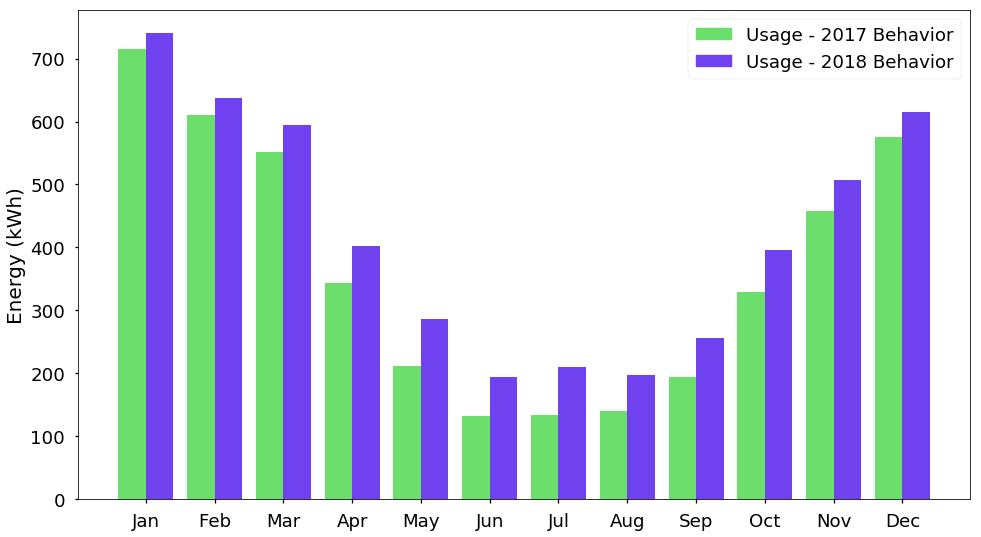

In [189]:
sns.set_context('talk', font_scale=1.4)
fig, ax = plt.subplots(figsize=(16, 9))

colors = ['#6CDE6B','#7041EE','#7570b3','#e7298a','#66a61e','#e6ab02']
width=0.4
grouped_tmy_df = daily_tmy_temps.groupby('month').agg('sum')[['energy_2017', 'energy_2018', 'carbon_g', 'marginal_carbon_g']].reset_index()


exe_1 = np.arange(0.3, 12, 1)
exe_2 = np.arange(0.7, 12, 1)

ax.bar(exe_1, grouped_tmy_df['energy_2017'], color=colors[0], width=width)
ax.bar(exe_2, grouped_tmy_df['energy_2018'], color=colors[1], width=width)

ax.set_xticks(np.arange(0.5, 12, 1))
ax.set_xticklabels(MONTH_ABB)
ax.set_ylabel('Energy (kWh)')

patch_2017 = mpatches.Patch(color=colors[0], label='Usage - 2017 Behavior')
patch_2018 = mpatches.Patch(color=colors[1], label='Usage - 2018 Behavior')

ax.legend(handles=[patch_2017, patch_2018], loc='upper right')
fig.savefig('slide_tmy3_2017vs2018.png', dpi=300)

local_time  month  year  N01_kWh  \
0      2016-12-31 19:15:00-05:00      1  2017     0.02   
1      2016-12-31 19:30:00-05:00      1  2017     0.03   
2      2016-12-31 19:45:00-05:00      1  2017     0.04   
3      2016-12-31 20:00:00-05:00      1  2017     0.02   
4      2016-12-31 20:15:00-05:00      1  2017     0.02   
5      2016-12-31 20:30:00-05:00      1  2017     0.05   
6      2016-12-31 20:45:00-05:00      1  2017     0.03   
7      2016-12-31 21:00:00-05:00      1  2017     0.04   
8      2016-12-31 21:15:00-05:00      1  2017     0.03   
9      2016-12-31 21:30:00-05:00      1  2017     0.03   
10     2016-12-31 21:45:00-05:00      1  2017     0.03   
11     2016-12-31 22:00:00-05:00      1  2017     0.03   
12     2016-12-31 22:15:00-05:00      1  2017     0.02   
13     2016-12-31 22:30:00-05:00      1  2017     0.04   
14     2016-12-31 22:45:00-05:00      1  2017     0.02   
15     2016-12-31 23:00:00-05:00      1  2017     0.02   
16     2016-12-31 23:15:00-05:00      1  2017     0.04   
17     2016-12-31 23:30:00-05:00      1  2017     0.03   
18     2016-12-31 23:45:00-05:00      1  2017     0.05   
19     2017-01-01 00:00:00-05:00      1  2017     0.45   
20     2017-01-01 00:15:00-05:00      1  2017     0.46   
21     2017-01-01 00:30:00-05:00      1  2017     0.45   
22     2017-01-01 00:45:00-05:00      1  2017     0.40   
23     2017-01-01 01:00:00-05:00      1  2017     0.38   
24     2017-01-01 01:15:00-05:00      1  2017     0.32   
25     2017-01-01 01:30:00-05:00      1  2017     0.41   
26     2017-01-01 01:45:00-05:00      1  2017     0.42   
27     2017-01-01 02:00:00-05:00      1  2017     0.47   
28     2017-01-01 02:15:00-05:00      1  2017     0.44   
29     2017-01-01 02:30:00-05:00      1  2017     0.44   
...                          ...    ...   ...      ...   
69849  2018-12-31 11:30:00-05:00     12  2018     0.15   
69850  2018-12-31 11:45:00-05:00     12  2018     0.08   
69851  2018-12-31 12:00:00-05:00     12  2018     0.13   
69852  2018-12-31 12:15:00-05:00     12  2018     0.44   
69853  2018-12-31 12:30:00-05:00     12  2018     0.32   
69854  2018-12-31 12:45:00-05:00     12  2018     0.12   
69855  2018-12-31 13:00:00-05:00     12  2018     0.09   
69856  2018-12-31 13:15:00-05:00     12  2018     0.55   
69857  2018-12-31 13:30:00-05:00     12  2018     1.38   
69858  2018-12-31 13:45:00-05:00     12  2018     1.09   
69859  2018-12-31 14:00:00-05:00     12  2018     0.82   
69860  2018-12-31 14:15:00-05:00     12  2018     0.18   
69861  2018-12-31 14:30:00-05:00     12  2018     0.14   
69862  2018-12-31 14:45:00-05:00     12  2018     0.30   
69863  2018-12-31 15:00:00-05:00     12  2018     0.30   
69864  2018-12-31 15:15:00-05:00     12  2018     0.08   
69865  2018-12-31 15:30:00-05:00     12  2018     0.23   
69866  2018-12-31 15:45:00-05:00     12  2018     0.38   
69867  2018-12-31 16:00:00-05:00     12  2018     0.13   
69868  2018-12-31 16:15:00-05:00     12  2018     0.09   
69869  2018-12-31 16:30:00-05:00     12  2018     0.09   
69870  2018-12-31 16:45:00-05:00     12  2018     0.05   
69871  2018-12-31 17:00:00-05:00     12  2018     0.06   
69872  2018-12-31 17:15:00-05:00     12  2018     0.05   
69873  2018-12-31 17:30:00-05:00     12  2018     0.07   
69874  2018-12-31 17:45:00-05:00     12  2018     0.04   
69875  2018-12-31 18:00:00-05:00     12  2018     0.07   
69876  2018-12-31 18:15:00-05:00     12  2018     0.07   
69877  2018-12-31 18:30:00-05:00     12  2018     0.08   
69878  2018-12-31 18:45:00-05:00     12  2018     0.06   

       marginal_carbon_g_per_kWh  carbon_g_per_kWh  
0                         490.00        237.176530  
1                         490.00        237.176530  
2                         490.00        232.710610  
3                         490.00        232.539621  
4                         490.00        233.873419  
5                         490.00        231.839626  
6                         490.00        232.347862  
7

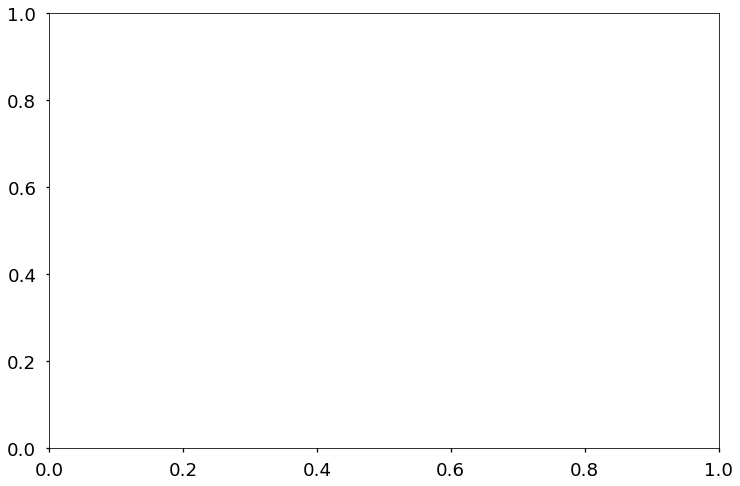

In [194]:
# slide on carbon footprint by month - to insert into sankey diagram - highlighting each month in turn
sns.set_context('talk', font_scale=1.4)
fig, ax = plt.subplots(figsize=(12, 8))
carbon_df = master_df[['local_time', 'month', 'year', 'N01_kWh', 'marginal_carbon_g_per_kWh','carbon_g_per_kWh']]
carbon_df['carbon_g'] = carbon_df['N01_kWh'] * carbon_df['carbon_g_per_kWh']
carbon_df['']

In [192]:
master_df.head()

Unnamed: 0_x          IntervalEnd  Interconnect_kWh  N01_kWh  NGEN_kWh  \
0             0  2017-01-01-00:15:00               0.0     0.02       0.0   
1             1  2017-01-01-00:30:00               0.0     0.03       0.0   
2             2  2017-01-01-00:45:00               0.0     0.04       0.0   
3             3  2017-01-01-01:00:00               0.0     0.02       0.0   
4             4  2017-01-01-01:15:00               0.0     0.02       0.0   

              datetime  hour  minute  hourofday  dayofmonth        ...         \
0  2017-01-01 00:15:00     0      15       0.25           1        ...          
1  2017-01-01 00:30:00     0      30       0.50           1        ...          
2  2017-01-01 00:45:00     0      45       0.75           1        ...          
3  2017-01-01 01:00:00     1       0       1.00           1        ...          
4  2017-01-01 01:15:00     1      15       1.25           1        ...          

   cdd  total_dd  powerwall_discharge  raw_consumption_estimation_kWh  \
0  0.0  0.267650                    0                            0.02   
1  0.0  0.264468                    0                            0.03   
2  0.0  0.261285                    0                            0.04   
3  0.0  0.260521                    0                            0.02   
4  0.0  0.263385                    0                            0.02   

  final_consumption_estimation_kWh  Unnamed: 0_y                 local_time  \
0                             0.02          5809  2016-12-31 19:15:00-05:00   
1                             0.03          5810  2016-12-31 19:30:00-05:00   
2                             0.04          5811  2016-12-31 19:45:00-05:00   
3                             0.02          5812  2016-12-31 20:00:00-05:00   
4                             0.02          5813  2016-12-31 20:15:00-05:00   

   solar_radiation_Wperm2  marginal_carbon_g_per_kWh  carbon_g_per_kWh  
0                0.445833                      490.0        237.176530  
1                0.383333                      490.0        237.176530  
2                0.320833                      490.0        232.710610  
3                0.258333                      490.0        232.539621  
4                0.195833                      490.0        233.873419  

[5 rows x 90 columns]

In [165]:
list(tmy3_df.columns)

['Date (MM/DD/YYYY)',
 'Time (HH:MM)',
 'ETR (W/m^2)',
 'ETRN (W/m^2)',
 'GHI (W/m^2)',
 'GHI source',
 'GHI uncert (%)',
 'DNI (W/m^2)',
 'DNI source',
 'DNI uncert (%)',
 'DHI (W/m^2)',
 'DHI source',
 'DHI uncert (%)',
 'GH illum (lx)',
 'GH illum source',
 'Global illum uncert (%)',
 'DN illum (lx)',
 'DN illum source',
 'DN illum uncert (%)',
 'DH illum (lx)',
 'DH illum source',
 'DH illum uncert (%)',
 'Zenith lum (cd/m^2)',
 'Zenith lum source',
 'Zenith lum uncert (%)',
 'TotCld (tenths)',
 'TotCld source',
 'TotCld uncert (code)',
 'OpqCld (tenths)',
 'OpqCld source',
 'OpqCld uncert (code)',
 'Dry-bulb (C)_x',
 'Dry-bulb source',
 'Dry-bulb uncert (code)',
 'Dew-point (C)',
 'Dew-point source',
 'Dew-point uncert (code)',
 'RHum (%)_x',
 'RHum source',
 'RHum uncert (code)',
 'Pressure (mbar)',
 'Pressure source',
 'Pressure uncert (code)',
 'Wdir (degrees)',
 'Wdir source',
 'Wdir uncert (code)',
 'Wspd (m/s)',
 'Wspd source',
 'Wspd uncert (code)',
 'Hvis (m)',
 'Hvis sour

(0, 50000)

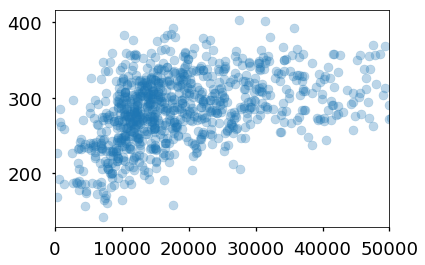

In [173]:
sam_df = tmy3_df.sample(1000)

plt.scatter(sam_df['RT_Demand']*sam_df['RT_LMP'], sam_df['carbon_g_per_kWh'], alpha=0.3)
plt.xlim(0, 50000)

['Unnamed: 0_x',
 'IntervalEnd',
 'Interconnect_kWh',
 'N01_kWh',
 'NGEN_kWh',
 'datetime',
 'hour',
 'minute',
 'hourofday',
 'dayofmonth',
 'month',
 'year',
 'dayofyear',
 'daysincebeginning',
 'Timestamp',
 'Dew point (C)',
 'Dew point (F)',
 'Dry-bulb (C)',
 'Dry-bulb (F)',
 'RHum (%)',
 'Sea level pressure (mbar)',
 'Station pressure (mbar)',
 'degree of saturation',
 'humidity ratio',
 'enthalpy (J/g ref 0C)',
 'enthalpy (Btu/lbm ref 0F)',
 'specific volume (m^3/kg)',
 'specific volume (ft^3/lbm)',
 'wet bulb temperature (C)',
 'wet bulb temperature (F)',
 'Hr_End',
 'DA_Demand',
 'RT_Demand',
 'DA_LMP',
 'DA_EC',
 'DA_CC',
 'DA_MLC',
 'RT_LMP',
 'RT_EC',
 'RT_CC',
 'RT_MLC',
 'Dry_Bulb',
 'Dew_Point',
 'produced_Wh',
 'solaredge_kW',
 'month_diff',
 'new_month',
 'net_energy_kWh',
 'net_power_kW',
 'rolling_sum',
 'credit',
 'plot_hour',
 'pd_date',
 'Begin Date',
 'Coal',
 'Natural Gas',
 'Nuclear',
 'Hydro',
 'Landfill Gas',
 'Refuse',
 'Solar',
 'Wind',
 'Wood',
 'Oil',
 'Ot

In [228]:
master_df[master_df['powerwall_discharge']==1]

Unnamed: 0_x          IntervalEnd  Interconnect_kWh  N01_kWh  NGEN_kWh  \
52098         52098  2018-06-29-18:45:00               NaN     0.00      1.21   
52099         52099  2018-06-29-19:00:00               NaN     0.00      1.18   
52100         52100  2018-06-29-19:15:00               NaN     0.00      1.15   
52101         52101  2018-06-29-19:30:00               NaN     0.00      1.15   
52102         52102  2018-06-29-19:45:00               NaN     0.00      1.14   
52103         52103  2018-06-29-20:00:00               NaN     0.00      1.14   
52104         52104  2018-06-29-20:15:00               NaN     0.00      1.09   
52105         52105  2018-06-29-20:30:00               NaN     0.00      1.06   
52106         52106  2018-06-29-20:45:00               NaN     0.00      1.09   
52107         52107  2018-06-29-21:00:00               NaN     0.00      1.14   
52194         52194  2018-06-30-18:45:00               NaN     0.00      1.30   
52195         52195  2018-06-30-19:00:00               NaN     0.00      1.26   
52196         52196  2018-06-30-19:15:00               NaN     0.00      1.26   
52197         52197  2018-06-30-19:30:00               NaN     0.00      1.28   
52198         52198  2018-06-30-19:45:00               NaN     0.00      1.23   
52199         52199  2018-06-30-20:00:00               NaN     0.00      1.21   
52200         52200  2018-06-30-20:15:00               NaN     0.00      1.19   
52201         52201  2018-06-30-20:30:00               NaN     0.00      1.20   
52202         52202  2018-06-30-20:45:00               NaN     0.00      1.19   
52203         52203  2018-06-30-21:00:00               NaN     0.00      1.20   
52375         52375  2018-07-02-16:00:00               NaN     0.00      2.05   
52376         52376  2018-07-02-16:15:00               NaN     0.00      2.05   
52377         52377  2018-07-02-16:30:00               NaN     0.00      2.00   
52378         52378  2018-07-02-16:45:00               NaN     0.00      1.96   
52379         52379  2018-07-02-17:00:00               NaN     0.00      1.88   
52380         52380  2018-07-02-17:15:00               NaN     0.00      1.79   
52381         52381  2018-07-02-17:30:00               NaN     0.00      1.78   
52382         52382  2018-07-02-17:45:00               NaN     0.00      1.62   
52383         52383  2018-07-02-18:00:00               NaN     0.00      1.53   
52404         52404  2018-07-02-23:15:00               NaN     0.00      1.03   
...             ...                  ...               ...      ...       ...   
66020         66020  2018-11-21-19:15:00               NaN     0.00      1.06   
66021         66021  2018-11-21-19:30:00               NaN     0.03      1.06   
66208         66208  2018-11-23-18:15:00               NaN     0.00      1.10   
66209         66209  2018-11-23-18:30:00               NaN     0.00      1.19   
66210         66210  2018-11-23-18:45:00               NaN     0.00      1.18   
66211         66211  2018-11-23-19:00:00               NaN     0.00      1.17   
66212         66212  2018-11-23-19:15:00               NaN     0.00      1.18   
67548         67548  2018-12-07-17:15:00               NaN     0.00      1.14   
67549         67549  2018-12-07-17:30:00               NaN     0.00      1.12   
67550         67550  2018-12-07-17:45:00               NaN     0.00      1.13   
67551         67551  2018-12-07-18:00:00               NaN     0.00      1.02   
67556         67556  2018-12-07-19:15:00               NaN     0.00      1.10   
68028         68028  2018-12-12-17:15:00               NaN     0.00      1.01   
68564         68564  2018-12-18-07:15:00               NaN     0.00      1.18   
68565         68565  2018-12-18-07:30:00               NaN     0.00      1.16   
68566         68566  2018-12-18-07:45:00               NaN     0.00      1.17   
68567         68567  2018-12-18-08:00:00               NaN     0.00      1.20   
68568         68568  2018-12-18-08:15:

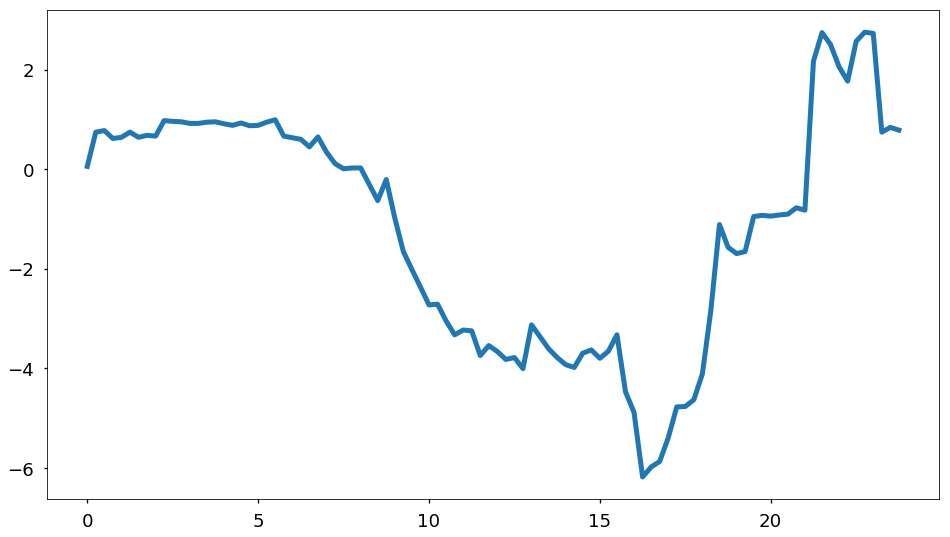

In [234]:
hot_powerwall_days = [604, 605, 607, 608, 610]
pw_day_df = master_df[master_df['daysincebeginning'].isin(hot_powerwall_days)][['hourofday', 'net_power_kW']]
gpw_df = pw_day_df.groupby('hourofday').agg(np.mean).reset_index()
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(gpw_df['hourofday'], -gpw_df['net_power_kW'], linewidth=5)

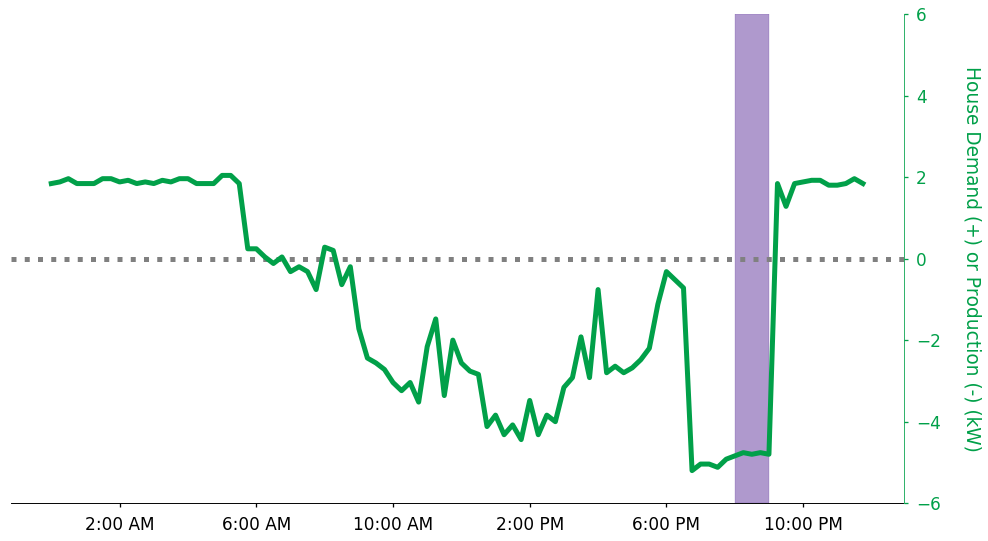

In [13]:
sns.set_context('talk', font_scale=1.3)

left_axis_color = 'xkcd:indigo'
right_axis_color = 'xkcd:emerald'
highlight_color = 'xkcd:berry'

# coincident value plot (?)
vermont_peak_df = pd.read_csv('../raw_data_files/vt_peak_data/vt_peaks.csv')
vermont_peak_df['network_peak_dt'] = vermont_peak_df['network_peak_day'].apply(lambda x: pd.to_datetime(x))
vermont_peak_df['iso_peak_dt'] = vermont_peak_df['iso_peak_day'].apply(lambda x: pd.to_datetime(x))

# get a list of peak days
peak_days = list(master_df[master_df['pandas_dt'].isin(vermont_peak_df['network_peak_dt'])]['daysincebeginning'])

def plot_coincidence_factor_day(day_df, filename_suffix=''):
    fig, ax = plt.subplots(figsize=(16,9))
    ax.plot(day_df['hourofday'], day_df['RT_Demand'], linewidth=5, color=left_axis_color)
    ax.set_ylim(400, 900)
    ax.set_xlim(0,24)
    ax.set_ylabel('Vermont Demand (MW)', color=left_axis_color)
    ax.tick_params(axis='y', colors=left_axis_color)
    xticks = [2, 6, 10, 14, 18, 22]
    xticklabels = ['2:00 AM', '6:00 AM', '10:00 AM', '2:00 PM', '6:00 PM', '10:00 PM']
    ax.spines['left'].set_color(left_axis_color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Hour of Day')
    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 20
    for_date = day_df[day_df['daysincebeginning']==605].iloc[0]
    ax.text(1, 860, f"{FULL_MONTH_NAMES[for_date['month']-1]} {for_date['dayofmonth']}, {for_date['year']}")
    
    fig.savefig(f'slide_coincidence_grid_{filename_suffix}.png', dpi=300)
    
    hour_of_interest = sample_df.loc[sample_df['RT_Demand'].idxmax()]['hourofday']
    ax.axvspan(hour_of_interest-1, hour_of_interest, color=left_axis_color, alpha=0.4)
    
    fig.savefig(f'slide_highlight_coincidence_grid_{filename_suffix}.png', dpi=300)
    
    plt.cla()
    ax.spines['left'].set_visible(False)
    ax.set_yticks([]) 
    ax2 = ax.twinx()
    ax2.axvspan(hour_of_interest-1, hour_of_interest, color=left_axis_color, alpha=0.4)
    ax2.axhline(0, 0, 24, color='grey', linewidth=5, linestyle=':')
    ax2.plot(day_df['hourofday'], -day_df['net_power_kW'], color=right_axis_color, linewidth=5)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(True)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_color(right_axis_color)
    ax2.set_ylim(-6, 6)
    ax2.set_ylabel('House Demand (+) or Production (-) (kW)', color=right_axis_color, rotation=-90)
    ax2.yaxis.labelpad = 40
    ax2.tick_params(axis='y', colors=right_axis_color)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticklabels)   

sample_df = master_df[master_df['daysincebeginning']==605]

plot_coincidence_factor_day(sample_df)


# find my house's maximum consumption on each day


# find the coincidence factor for each time of each day
# find plot house coincidence factors for vermont peaks by month

# plot example daily loadshape before powerwall and after powerwall, with coincidence factor marked.

# plot month bar plot before powerwall and after powerwall coincidence factors


In [62]:
for_date = master_df[master_df['daysincebeginning']==605].iloc[0]
for_date

Unnamed: 0_x                                            52119
IntervalEnd                               2018-06-30-00:00:00
Interconnect_kWh                                          NaN
N01_kWh                                                  0.46
NGEN_kWh                                                    0
datetime                                  2018-06-30 00:00:00
hour                                                        0
minute                                                      0
hourofday                                                   0
dayofmonth                                                 30
month                                                       6
year                                                     2018
dayofyear                                                 181
daysincebeginning                                         605
Timestamp                           2018-06-29 20:00:00-04:00
Dew point (C)                                            17.2
Dew poin

In [69]:
f"{FULL_MONTH_NAMES[for_date['month']-1]} {for_date['dayofmonth']}, {for_date['year']}"

'June 30, 2018'

In [83]:
sample_df.loc[sample_df['RT_Demand'].idxmax()]['hourofday']

21.0